# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Friday September 29th at 12pm PDT.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

Q1: What are some real world applications of dense sentence embeddings?

Answer: To list a few:
- Dense sentece embeddings are used to perform semantic similarity search, a common set up for this is the following:
  - Define embeddings for the sentences in you database and store them in a vector database
  - Take a query and get its embedding
  - Look for the most similar (close) vectors in the database and rank them according to similarity.

 This setup can be used for many tasks, for example, to peform information retrieval on large documents (pieces of the documents are considered as separate texts), or to create recomendation systems.    
- Language translation: If we have corresponding pairs of sentences (called parallel sentences), each one in different languages, we can train LLM to provide similar embeddings to each element of the pair. With this setup we have embeddings that are language agnostic, moreover, we can add a decoder on top of the language agnostic encoder such that we can perform translation.
- Mutlimodal search: LLM and combined with image generating models to provide similar embeddigns for both images and their descriptions, such that, if a new description is provided we can look for images whose embeddings are close to the embedding of the description.

Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

Answer: Some of these can be:
- Using bag of words: one of the most simple ways of creating a vector, you just need to count how many times a word appears in a given text.
- Using Tf-IDF representation of the sentences, it is widely used cause it provides a nice way to understand topics from clusters of texts. It extends the bag of words representation by taking into account that common words provide little semantic information.
- Using the mean of word emebddings: Use word embedding models like GloVe or Word2Vec to encode each word in a sentence, and then take an average over all the words in the sentence. This is a nice way fo gettin semantic meaning out of the embeddigns but we still have no information about the sentence structure (what comes after what).
- Use Recurrent neural networks to generated sentence embeddings: not sure if these are not catalogued as LLM, but in case they are not, these are the predecesors to the tranformers and used to be the SOTA before them. One of the best example of these models is the [InferSent](https://arxiv.org/pdf/1705.02364.pdf) model.



**Imports**

# Runtime and Setup

**Make sure that you use the runtime with a T4 GPU so that the computations are done faster, if it is not used connect to a T4 runtime and import the libraries again. If you are executing this notebook this will give you aproox a x5 speed up on the training and inference times.**

In [ ]:
# I will connect to google colab so that I do not need to download the datasets and bin files everytime I execute this notebook
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Cohere_scholars_application_2023/TakeHomeAssignement'
! ls

In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
%pip install transformers
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel
from transformers import AutoModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00


In [ ]:
# I know that I am not supposed to load more libraries, but thie library contains no
# funcitonalities of NN, it just an aid to better visualize the data and analyse the results
# they are not used to take shortcuts to the problems. This allow me to give a good narrative
# to my process through the assignement
from pprint import pprint as pp
# To plot
import matplotlib.pyplot as plt
import seaborn as sns

## **Coding Challenge Part 1: Debugging custom BERT code [7 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 7 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 7 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

In [ ]:
# @title
"""
Original version of the code
"""


def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):
    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.9,
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        u = x.mean(0, keepdim=True)
        s = (x + u).pow(2).mean(0, keepdim=True)
        x = (x + u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class MLP(nn.Module):
      def __init__(self, hidden_size, intermediate_size):
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x


class Layer(nn.Module):
    def __init__(self, config):
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        s = torch.matmul(q, k)
        s = s / math.sqrt(self.attention_head_size)

        s = torch.where(mask, s, torch.tensor(float('inf')))

        p = s
        p = self.dropout(p)

        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):
        q, k, v = self.query(x), self.key(x), self.value(x)

        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)
        a = self.dropout(a)
        a = self.ln1(a)

        m = self.mlp(a)
        m = self.dropout(m)
        m = self.ln2(m)

        return m


class Bert(nn.Module):
      def __init__(self, config_dict):
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)

        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        x = torch.cat((self.embeddings.token(input_ids),
                       self.embeddings.position(position_ids),
                       self.embeddings.token_type(token_type_ids)),
                      dim=-1)
        x = self.dropout(self.ln(x))

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        self.load_state_dict(torch.load(path))
        return self

**Personal comment:**
This has been my first time in looking into teh insides of a BERT model, it has been as very fun experience. This being said, I have to admit that tacklig this coding challenge would have been much harder if not for the help of the AI serach engine [phind](https://www.phind.com/). I did not recall reading anything that prohibited the use of those tools, I hope that did not missed something.

### Methodology of solution

First I tried to debug the code as I would do with a normal python code, but I came across the challenge that I did not know about what the code was supposed to do, so, after a couple of hours failing to debug it I decided to check what is the object created by the huggign face library when the model is loaded, and compare the sourece code of that object with the source code provided.

So, I will gide you throug my process.

In [ ]:
# Load the hugging face model and give it a distinctive name so we can use it as our baseline
MODEL_NAME = 'prajjwal1/bert-tiny'
bert_hf = AutoModel.from_pretrained(MODEL_NAME)
type(bert_hf)

transformers.models.bert.modeling_bert.BertModel

The type function tell us that the object is a `BertModel`, whose source code can be found in the directory

https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py

I will compare the code of the `BertModel` and its constituents to modify and characterize the code that is gvien.

In [ ]:
# Lets check the attributes of the BertModel, I will expect these to correspond one to one with the attributes of the
# classes defined in code cell where the Bert class is defined
bert_hf.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('embeddings',
               BertEmbeddings(
                 (word_embeddings): Embedding(30522, 128, padding_idx=0)
                 (position_embeddings): Embedding(512, 128)
                 (token_type_embeddings): Embedding(2, 128)
                 (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
                 (dropout): Dropout(p=0.1, inplace=False)
               )),
          

In [ ]:
#Check that the hugging face model works
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output_hf = bert_hf(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
# When using hte hugging face model we can use pooler_output key to get the pooled output
# https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L1040-L1047
embedding_hf = output_hf["pooler_output"]
#embedding_hf = output_hf[1]
print(f'\nResulting embedding shape: {embedding_hf.shape}')


Resulting embedding shape: torch.Size([1, 128])


In [ ]:
# Lets check the type of the tokenizer
type(tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [ ]:
# look at the output of the model
output_hf

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.4922, -0.1447, -3.9635,  ..., -2.3877, -2.4181, -0.5727],
         [-1.7495,  0.4426, -0.5961,  ..., -2.4526, -1.6050, -0.5465],
         [-1.8891,  0.1500, -0.2990,  ..., -1.9714, -1.0250, -0.2036],
         ...,
         [-0.6833,  0.4101, -0.3581,  ..., -2.9989, -1.7839,  0.5004],
         [-0.3580,  0.6341, -1.0141,  ..., -2.6826, -2.3256, -0.5316],
         [ 0.2038, -0.0467, -2.9818,  ..., -2.2861, -2.2358,  0.3597]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-9.9999e-01, -5.5475e-02, -9.9157e-01,  8.1060e-01, -9.9438e-01,
          7.2141e-01, -9.9686e-01, -8.4056e-01,  1.7510e-03, -5.4187e-02,
         -6.4888e-01, -4.9243e-02,  3.8724e-02,  9.9988e-01,  3.0043e-01,
         -9.0879e-01,  8.9856e-01,  1.9960e-01, -6.8852e-01,  2.6057e-01,
          9.3974e-01, -1.8262e-01,  4.9482e-01, -6.5103e-01, -9.9959e-01,
         -1.0319e-01, -9.9980e-01,  9.3092e-01,  9.6353e-01,  4.060

In [ ]:
# look at the configuraion of the model
# WE find that this model is not a decoder, which is important to compare this code with the code from the huggign face repo
bert_hf.config

BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
# Chekc the output of the Tokeniser
tokenized_sample['input_ids'].shape

torch.Size([1, 512])

In [ ]:
# This is an equivalent way of passing the information to the bert model using  a dictionary unraveling
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
sentence2 = 'Somethig to test the bert model on'
# If we pass to sentences to the tokenizer it gives us a vector of dim (2,max_length) for each of the attributes of the tokenizer
# As we can check in documentation were it says that is returns a BatchEncoding
# https://huggingface.co/transformers/v3.3.1/main_classes/tokenizer.html#transformers.PreTrainedTokenizerFast.__call__
# and we can check it
tokenized_sample = tokenizer([sentence,sentence2], return_tensors='pt', padding='max_length', max_length=512)
print(type(tokenized_sample))
print("\nSize of the input_ids given by the tokenizer ",tokenized_sample["input_ids"].shape)
# Run the model and checke that it gave us the result of both computations, as we can check from the official documentation
# of the BertModel https://huggingface.co/transformers/v4.7.0/model_doc/bert.html#transformers.BertModel.forward
output_hf = bert_hf(**tokenized_sample)
embedding_hf = output_hf["pooler_output"]
print(f'\nResulting embedding shape: {embedding_hf.shape}')

<class 'transformers.tokenization_utils_base.BatchEncoding'>

Size of the input_ids given by the tokenizer  torch.Size([2, 512])

Resulting embedding shape: torch.Size([2, 128])



By today I have not been to get the expected results out of the `Bert` model, but I have been ale to get a model that gives half the correlation, so, it is an improvement over the model I originally implemented that gave me no correaltions at all, so, it is a start.

I tried usin a debugger

Also, look into the bert tutorials (find the original bert paper):
- https://medium.com/@samia.khalid/bert-explained-a-complete-guide-with-theory-and-tutorial-3ac9ebc8fa7c
- https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270



As I will mentioned later, after failing at my second attempt of finding bugs of the Bert model provided I decided to use pdb to track down the operations beign made by the BertModel. There is a way to do this in colab, I will add that code for this in the following code cell, however, colab is not the best option for this approach. Eitherway it was my firs attempt and I learn some new things, but for my second attempt I will do it locally so I can use an IDE for this.

In a nutshell, the step I will follow are:
- Add `breakpoints` in places that I deem importat in the code, to chekc what are the alues of varibles in those places.
- I sill use `n`, `s` pdb commands to navitage over the programs step by step and check how are the computations being made.
- Hopefully this will take me to the places where the remaining bugs are.

In [ ]:
# @title
# Install pdb for interactive sessions
!pip install -Uqq ipdb
import ipdb
# Set the amount of lines of the source code you will like to see when stoppig at a certain point of the source code
ipdb.set_trace(context=6)
# DEfine a function that does the operation we want to debugg, if we try to debugg the BertModel in the interactive
# session directly this will cause us to go into the code on jupyter instead of the code of the BertModel
def get_vector(model, tokenized_sample):
  ipdb.set_trace(context=6)
  vector = model(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)
  return vector
# Set pdb on and start looking into the code one line at the time
%pdb on
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
vector = get_vector(bert_hf, tokenized_sample)

**Bugs**

I have modified the variable names so that is easier to understand what is doing the `Bert` class.

Without further ado these are the bugs I have found in the `Bert` class, all but thge first one will have an impact in the resutls of the second point. The first one will only impact the third and fourth points were the dropout probability comes in play (when we train the neural network).  

1. Set the correct value for the droput probability, ti needs to be in `0.1` and was in `0.9` in the `Config` class. This is related to the ther bug on related to Dropouts, turns out that any model is set to evaluation mode when loaded according to the [documentation](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/auto/auto_factory.py#L87-L88), this can be correborated by looking at the `from_pretrained` function for Hugging Face [PreTrainedModel](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/modeling_utils.py#L3211-L3212) class. So, we need to add the line
```
self.eval()
```
after creating the model in the function  `load_model`. Recall that pytorch sets the models to `train` mode by [default](https://pytorch.org/tutorials/beginner/saving_loading_models.html). I added two new varibles to the config so that we have a separate default values for hidden opperations dropout and the dropout prob for the attention, is not needed but it made be easir to understand the code.
 - Setting the model to `eval` once created was the most difficult bug to find for me, this came to me once after going through point 3 and noticing that there where to modes for pytorch models. So, I went back to the computation of the definition of the model and set a very low probability dropout to check what would happen, and I realice that I got the proper behaviour out of the model.


2. The `forward` method of the layer normalizaion is not porperly computed:
  ```
    def forward(self, x):
      u = x.mean(0, keepdim=True)
      s = (x + u).pow(2).mean(0, keepdim=True)
      x = (x + u) / torch.sqrt(s + self.variance_epsilon)
      return self.gamma * x + self.beta
      ````
  the mean needs to be coputed along the last dimension, then it needs to be substracted from x to compute the variance. Or you can use the function `F.layer_norm` to compute it. This is explained in the documentation of the [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html?highlight=layernorm#torch.nn.LayerNorm) class of pytorch.
3. The embeddings need to be added and not concatenated, that is why the piece of code gives the incorrect way of generating the embeddings
```
x = torch.cat((self.embeddings.token(input_ids),
    self.embeddings.position(position_ids),
    self.embeddings.token_type(token_type_ids)),
  dim=-1)
```
  and causes the following layer normalization to fail
  `x = self.dropout(self.ln(x))`, instead, the embeddinds need to be added to get the final [embedding ](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L235-L238).
4. The output of the layers is not only the result of applying the neural network, but instead, it is the sum of the input info and the output of the neural network, this helps to prevent the vanishing gradient effect. For example, this needs to be done in the last part of the froward method of the Bert layer.
  ```
  m = self.mlp(a)
  m = self.dropout(m)
  m = self.ln2(m)
  ```
  the last normalizatio shoudl be computed as `m = self.ln2(m+a)` as in the [HF implementation](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L463-L467).

  A simliar thing happens in the computation of the self attention, where the input of the self attention i.e. `x` needs to be added to the result of the layer norm that finishes the self attention computation
  ```
  def forward(self, x, attention_mask):
      q, k, v = self.query(x), self.key(x), self.value(x)

      q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
      k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
      v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

      a = self.attn(q, k, v, attention_mask)
      a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
      a = self.attn_out(a)
      a = self.dropout(a)
      a = self.ln1(a)
  ```
  So, in the last line it should be `a = self.ln1(a+x)` as is done in the [Bert model of HF](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L436)
5. The attention mask is applied incorreclty, in the riginal implementation
 ```
 s = torch.where(mask, s, torch.tensor(float('inf')))
 ```
  we set to `inf` the lemente where the mask is cero, i.e. where `attention_mask == False`. This may cause computational issues cause teh activations functions take `inf` value in `inf`, but we want is that the activation fucntions take the value 0 then we mask the token. So, we need to set the values to `-inf`, such that the previous opperation will behave similar to adding `-inf` in the place where there is no mask, which is the standard way of applyin the mask in the [HF model](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L350-L352).

6. There is no application of the softmax funciton after applying the mask, which causes numeric instabilities due to the `-inf` intriduced by the mask. So, after executing the line
```
s = torch.where(mask, s, torch.tensor(float('inf')))
```
we should apply a softmax layer as is done in the [HF Bert model](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L355), also, these gives of the probilities of the attention.

7. The key tensor is not reshaped so that it can be operated with the query tensor, so, this
```
s = torch.matmul(q, k)
```
should change to
```
s = torch.matmul(q, k.transpose(-1, -2))
```
as is done in the [BertModel from HG](https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L325).



In [ ]:
"""
Version revised by Juan
"""


def gelu(x):
    """
    Exact implementation of the GELU activation function using pytorch natives
    https://pytorch.org/docs/2.1/generated/torch.nn.functional.gelu.html
    instead of the torch version
    torch.nn.fucntional.gelu

    The explicit description of the exact gelu function is given by
    GELU(x) = 0.5x(1 + erf(x / sqrt(2)))
    whicih you can check in
    https://paperswithcode.com/method/gelu

    An approximated implementation is given by
    GELU(x) = 0.5x(1 + tanh(sqrt(2/pi)(x + 0.044715x^3)))

    """
    # A simplified version
    # return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    # Exact version
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
    # If no errors are found then use the GELU fucntion from pytorch
    #return F.gelu(x)


class Config(object):
    """
    Class to read te configuration of the BERT model.

    The following is the config of the model loaded from hugging face, it was differente from the
    config used by the Bert implementaiton fo this notebook, thus, I add it here for reference

    BertConfig {
      "_name_or_path": "prajjwal1/bert-tiny",
      "attention_probs_dropout_prob": 0.1,
      "classifier_dropout": null,
      "hidden_act": "gelu",
      "hidden_dropout_prob": 0.1,
      "hidden_size": 128,
      "initializer_range": 0.02,
      "intermediate_size": 512,
      "layer_norm_eps": 1e-12,
      "max_position_embeddings": 512,
      "model_type": "bert",
      "num_attention_heads": 2,
      "num_hidden_layers": 2,
      "pad_token_id": 0,
      "position_embedding_type": "absolute",
      "transformers_version": "4.33.2",
      "type_vocab_size": 2,
      "use_cache": true,
      "vocab_size": 30522
    }

    """
    def __init__(self,
                vocab_size=30522,
                hidden_size=128,
                num_hidden_layers=2,
                num_attention_heads=2,
                intermediate_size=512,
                hidden_dropout_prob=0.1,
                attention_probs_dropout_prob=0.1,
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        config = Config()
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      """
      Normalization layer for the bert Model

      A detour:
        This is supposed to be an explicit python implementation of the class nn.LayerNorm from pytorch:
        https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
        however, it does not have the implementation of the layer normalization.

        The class nn.LayerNorm uses the API torch.nn.fucntion.layer_norm, which belongs to the
        submodule functional, that was implemented to provide access to fucntions used in NN operationes
        without the need for importing modules:
        https://pytorch.org/docs/stable/generated/torch.nn.functional.layer_norm.html?highlight=f+layer_norm#torch.nn.functional.layer_norm

        The implementation of the torch.layer_norm function is in the torch library under the C++ files, that
        are called through the Aten library, whose source code can be found in the pytorch repository:
        https://github.com/pytorch/pytorch/tree/main/aten/src/ATen
        I gave a quick look at the tutorial on creating C++ modules for pytorch
        https://pytorch.org/tutorials/advanced/cpp_extension.html
        but I have not been able to understand how pybind11 creates the pytorch modules from C++ code.
        A tried to backtrace the layer normalization but I was not able to understand how it is implemented
        in the C++ code. Working with both python and C++ would be something I would really enjoy if I get to
        be part of the Scholars programm.


        In particular, the function that are visible to python need to the implemented inside the native directory of the
        Aten library:
        https://github.com/pytorch/pytorch/tree/main/aten/src/ATen/native#registering-a-function-in-native_functionsyaml

        and they need to be described in the file native_functions.yaml
        https://github.com/pytorch/pytorch/blob/main/aten/src/ATen/native/native_functions.yaml

        for example, IIANM the layer norm function is defined in
        https://github.com/pytorch/pytorch/blob/e42d450a555c1577fb8cee3f7ccde3532833f9a7/aten/src/ATen/native/native_functions.yaml#L3173-L3175

        which needs to be interpreted using the codegen
        https://github.com/pytorch/pytorch/blob/main/torchgen/gen.py

        So, I believe it calles the function layer_norm_symint from
        https://github.com/pytorch/pytorch/blob/e42d450a555c1577fb8cee3f7ccde3532833f9a7/aten/src/ATen/native/layer_norm.cpp#L184-L196

        but I have not been ale to find the actual implementation of the function. I will stop here,
        if you know where is the actual implementation of the function layer_norm
        I would like to know it. Also, if you know how is the python API calling the C++ modules
        I would like to know, this attemp to come up with an explanation did not have a successful ending :(

        Eitherway, I believe we should use the function nn.LayerNorm instead to avoid adding python boilerplate.

        Also, the computation in forward is done wrong, I will fix it.

      Mistakes:
        1. The mean is not substracte but added
        2. The variance is not cimputed correctlyu, it is the mean of the square distances to the mean, not the
          distance to the - mean.

      """


      def __init__(self, hidden_size, variance_epsilon=1e-12):
        """
        Args:
        hidden_size: dimension of the hidden representation of the Bert encoder
        variance_epsilon: small number to avoid diving by zero in case the variance is zero
        """

        super(LayerNorm, self).__init__()
        # Size of the layer
        self.hidden_size = hidden_size
        # Learnable parameters of the layer normalization
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        # Parameter added to the denominator for numerical stability
        self.variance_epsilon = variance_epsilon


      def forward(self, hidden_states):
        """
        Apply Layer normalization, the normalization is done over the last dimension i.e. the hidden representation of each token

        Args:
        hidden_states: vector of hidden representation of the bert model, with dimension
          (batch_size, sequence_len, hidden_dim)

        Returns:
        hidden_states: torch tensor representing the hidden representation of the tokens,
          has dimensions (batch_size, sequence_len, hidden_sim)
        """
        # Compute the mean for the hidden vectors, that is why we perform the operation over the last dim
        mean = hidden_states.mean(dim=-1, keepdim=True)
        # Compute the variance for the hidden vectors, that is why we perform the operation over the last dim
        var = hidden_states.var(dim=-1, keepdim=True, unbiased=False)
        # normalize the vector
        hidden_states_norm = (hidden_states - mean) / torch.sqrt(var + self.variance_epsilon)
        # Multiply by the parameters
        return hidden_states_norm * self.gamma + self.beta
        # If no mistakes are found then try using the default layer normalization from pytorh
        # return F.layer_norm(hidden_states,(self.hidden_size,),self.gamma, self.beta,self.variance_epsilon)

class MLP(nn.Module):
      """
      Apply BertIntermediate and the first linear transformation of BertOutput
        BertIntermediate: https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L441
        BertOutput: https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L456

      Apply Multilayer perceptron that goes after the computation of the contex layer
      (the context layer has the information of the attention mechanism)

      I believe this part is properly implemented
      """


      def __init__(self, hidden_size, intermediate_size):
        """
        Create the placeholders for the two linear tranformations applied in the transformation.
        The transformation is done over the last dimension, i.e. the hidden representation of each token

        Args:
        hidden_size: dimension of the hidden representation of the Bert encoder
        intermediate_size: dimension of the intermediate representation used between the
          BertIntermediate and BertOutput

        """
        super(MLP, self).__init__()
        # The class nn.Linear applies a linear tranformation to a tensor
        # x A^T + b, with x the tensor, A the weights and b the bias
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, hidden_states):
        """
        Apply a two layer NN transformation
        The activation function is given by the function `gelu`
        The transformation is done over the last dimension, i.e. the hidden representation of each token

        Args:
        hidden_states: torch tensor representing the hidden representation of the tokens,
          has dimensions (batch_size, sequence_len, hidden_sim)

        Returns:
        hidden_states: torch tensor representing the hidden representation of the tokens,
          has dimensions (batch_size, sequence_len, hidden_sim)
        """
        ### start BertIntermediate
        # Apply first linear transformation
        hidden_states = self.dense_expansion(hidden_states)
        # Apply regularization to get the intermediate representation of the hidden states
        # Since the original config has as hidden_act the alues 'gelu'
        hidden_states = gelu(hidden_states)
        ### End BertIntermediate

        ### start BertOutput
        # apply a linear transformation to perform the first step of computing the output of the Bert encoder model
        hidden_states = self.dense_contraction(hidden_states)
        return hidden_states


class Layer(nn.Module):
    """
    Implementation of a BertLayer, it is implemented in
    https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L470


    """

    def __init__(self, config):
        super(Layer, self).__init__()

        ############ Define BertAttention
        # These are the paramerters needed for a simple implementation of the Bert Attention Class
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L392
        # Which consists of two parts,
        # The Self attention class that implements the attention mechanism
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L244
        # And the output class that performs a one layer pass over a MLP, a droppout and a layer normalization
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L378


        ##### Set Elements of BertSelfAttention class
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L244
        # Set the paremeters for the multihead attention
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        # Check that the parameters are set properly
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L247C9-L251C14
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        # we do not have an embedding_size parameter in the config dictionary, thus, the previous computation must be exact
        # thus self.all_head_size == self.hidden_size
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # We are using the "absolute" position embedding

        # Under our assumptions we have that self.all_head_size = config.hidden_size
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout_attention = nn.Dropout(config.attention_probs_dropout_prob)
        ##### Finish elements of BertSelfAttention

        ##### Set elements of the BertSelfOutput class
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L378
        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        # This needs to be the dropout probability of the hidden states and not the dropoput probability of the attention probabilities
        self.dropout_hidden = nn.Dropout(config.hidden_dropout_prob)
        self.ln1 = LayerNorm(config.hidden_size)
        ##### Finish element of BertSelfOutput class

        ############ Finish elements of BertAttention

        ########### Define the elements of the BertIntermedite and BertOutput
        # This fucntions are applied through the feed_forward_chunk function,
        # which corresponds to this piece of code
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L550
        # and in turn is executed using an auxiliary function that divides the computations into chunks,
        # https://github.com/huggingface/transformers/blob/5936c8c57ccb2bda3b3f28856a7ef992c5c9f451/src/transformers/pytorch_utils.py#L168
        # in this case takes the trivial form of applying the BertIntermediate and BertOutput to each vector
        # Set parameters for the Feed Forward NN after the attention
        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

        ############ Finish elements of BertIntermedite and BertOutput


    def split_heads(self, tensor, num_heads, attention_head_size):
        """
        Implemenation of the transpose_for_scores function found in
        https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L271

        Divide the last dimension of the tensor into mutliple heads, each one will compute the attention
        score independently.

        We have that
        num_heads*attention_head_size == hidden_dim
        that is, the hidden dimensions are divided equally between
        heads of the model.

        Args:
        tensor: tensor of shape (batch_size, sequence_len,hidden_dim)
        num_heads: amount of attention heads
        attention_head_size: amount of dimensions per each head

        Return:
        tensor of shape (batch_size, num_heads, seq_length, dim_heads), which is used to apply the opperations indepently per
          each head

        """
        # Set the new shape of the vector, recall that hidden_size == num_heads * attention_head_size
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        # Reshape the tensor
        # The officaildocumentaion uses
        # x = x.view(new_x_shape)
        # but afaik those do the same
        #tensor = tensor.view(*new_shape)
        tensor = tensor.view(new_shape)
        # Reorder the tensor such that the second dimension corresponds to the number of heads, and the third and fourth corresponde to the
        # amount of tokens and the size of the attention heads. The shape of the tensor looks like
        # (batch_size, num_heads, seq_length, dim_heads)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """
        Implementation of the last part of the forwar mnethod in self attention
        https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L367-L369

        Combine the results of the operations comming from all the heads, this is done by reshaping the tensors
        into their original shape

        We have that
        num_heads*attention_head_size == hidden_dim
        that is, the hidden dimensions are divided equally between
        heads of the model.

        Args:
        tensor: tensor of shape  (batch_size, num_heads, seq_length, dim_heads)
        num_heads: amount of attention heads
        attention_head_size: amount of dimensions per each head

        Returns:
        tensor: tensor of shape (batch_size, sequence_len,hidden_dim)
        """
        # Reshape the tensor into the form
        # (batch_size, seq_length, num_heads, head_dim)
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        # Mix the last two dimensions into one, using the equation
        # self.all_head_size = self.num_attention_heads * self.attention_head_size
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        # Merge the last two dimensions so that the new tensor has the shape
        # (batch_size, seq_length, all_head_size) or equivalently (batch_size, seq_length, hidden_dim)
        return tensor.view(new_shape)


    def attn(self, query_layer, key_layer, value_layer, attention_mask):
        """
        Compute the context layer using the attention mechanism, as in the BertModel
        https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L324-L365

        Compute the attention probaiblities and used them to compute the contex layer,
        that is, the layer that takes into accout the values of the tokens along side
        the query and key attention.

        Args:
        query_layer: tensor of shape (batch_size, num_heads, seq_length, dim_heads)
        key_layer: tensor of shape (batch_size, num_heads, seq_length, dim_heads)
        value_layer: tensor of shape (batch_size, num_heads, seq_length, dim_heads)
        attention_mask: tensor of shape (batch_size, seq_length)

        Returns:
        context_layer: tensor of shape (batch_size, num_heads, seq_length, dim_heads)
          that contains the information of the attention.
        """
        # Generate a tensor of shape (batch_size, sequence_len) that has True if there is a mask
        # and Fals otherwise
        mask = attention_mask == 1
        # Augment the size of the vector into (batch_size, 1,1, sequence_len), this is a similar procedure to he one in
        # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/modeling_utils.py#L925
        # However, in this case the tensor has boolena values instead of numeric
        # In the implemntaion of HF this tensor is further trasnformed into a tensor fill with float numbers with 0 whre there are tokens and
        # -inf (torch.finfo(dtype).min) where there are no tokens, such that when added to any other tensor it gives the tensor value where
        # there are tokens and -inf where there are not
        # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/modeling_utils.py#L936-L938
        # however, we will use a tensor wuth boolean values and an alternative wawy of applying the mask
        mask = mask.unsqueeze(1).unsqueeze(2)


        # Transpose the key tensor so that it can be multiplied with the query tensor
        # then compute the raw attention scores, that is, an unnormalized attention scores
        # key.transpose(-1,-2) has shape (batch_size, num_heads, dim_heads, seq_length)
        # The result of this multiplication has shape (batch_size, num_heads, seq_length, seq_length)
        # and containes the information of the effect of each query in each key, that is why the last two dimensions are (seq_length, seq_length)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        # Normalize the attention outputs according to the size of the attention heads
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Apply the attention mask, in this case we set to '-inf' the entrie where the mask is 0, or equivalently, is False.
        # An alternative way of appyling the atttentio mask is to sum a vector that has -inf where the mask is 0, as is done in the HF implementation:
        # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L350-L352
        # notice that we can do this because the first and last dimensions of attention_scores are (batch_size, seq_length)
        attention_scores = torch.where(mask, attention_scores, torch.tensor(float('-inf')))

        # Use a Softmax to normalize the values of the attention scores, such that, if the mask takes value 0 then the attention probabilites are 0
        # This is useful for numerical stability and interpretability for the model
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # Droopout entire tokens, it is implemented in the original BERT paper
        attention_probs = self.dropout_attention(attention_probs)

        # Use the attention probabilities to weight the information inside the value tensor
        # We do NOT return the attention_probabilities
        # atention_probs has shape (batch_size, num_heads, seq_length, seq_length) and value has shape (batch_size, num_heads, seq_length, dim_heads)
        # thus the resulting vector has shape (batch_size, num_heads, seq_length, dim_heads), and contianes the effecto of the attetnion on the values
        context_layer = torch.matmul(attention_probs,value_layer)
        return context_layer

    def forward(self, hidden_states, attention_mask):
        """
        Apply the Bert Layer

        Args:
        hidden_states: tensor with shape (batch_size,sequence_len,hidden_dim) where for the element n of the batch
          and and the position k the sequence, we get the hidden representation of the token k in the n position of the batch
          is given by hidden_states[n.k]

        attention_mask: tensor with information of the attention mask, has shape (batch_size, sequence_len),
          it has 1 where there are tokens and 0 otherwise,

        Returns:
        layer_output: result of applying the bert layer to the tensor hidden_states, it is a
          tensor with shape (batch_size,sequence_len,hidden_dim) where for the element n of the batch
          and and the position k the sequence, we get the hidden representation of the token k in the n
          position of the batch is given by hidden_states[n.k]
        """
        ######### Apply the BertAttention

        ##### Start the BertSelfAttention
        # Apply steps from
        # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L286C9-L311
        mixed_query_layer, mixed_key_layer, mixed_value_layer = self.query(hidden_states), self.key(hidden_states), self.value(hidden_states)
        # Reorder the dimensions to coincide with the number of heads and the size of each head
        query_layer = self.split_heads(mixed_query_layer, self.num_attention_heads, self.attention_head_size)
        key_layer = self.split_heads(mixed_key_layer, self.num_attention_heads, self.attention_head_size)
        value_layer = self.split_heads(mixed_value_layer, self.num_attention_heads, self.attention_head_size)
        # These three vectors have shape (batch_size, num_heads, seq_length, dim_heads)
        # Compute the context layer using the attention mechanism
        # Apply steps from https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L325-L375
        context_layer = self.attn(query_layer, key_layer, value_layer, attention_mask)
        # Rearange outputs to get the self attention outputs
        selfattention_output = self.merge_heads(context_layer, self.num_attention_heads, self.attention_head_size)
        # This vector has shape (batch_size, seq_length, hidden_dim)
        ##### Finish the BertSelfAttention

        ##### Start the BertSelfOutput
        # Apply steps from
        # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L436
        inner_hidden_state = self.attn_out(selfattention_output)
        # This should be the dropout of the hidden vectors instead of the dropout probability of the attention heads
        inner_hidden_state = self.dropout_hidden(inner_hidden_state)
        # according to the BertSelfOutput the normalization should be done over a + x
        # which is done to mitigate the effect of the vanishing gradient, also this helps the
        # model focus on the changes it needs to make to the input, those changes are made through the
        # self attention outputs
        bert_attention_output = self.ln1(inner_hidden_state + hidden_states)
        # This vector has shape (batch_size, seq_length, hidden_dim)
        ##### Finish the BertSelfOutput

        ######### Finish the BertAttention


        ######### Apply the BertIntermedite and BertOutput
        # Apply intermediate function
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L441
        # And output function
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L456
        inner_hidden_states = self.mlp(bert_attention_output)
        # This dropout probability should be the dropout probability of the hidden representation and not the dropout probability of the attention probabilities
        inner_hidden_states = self.dropout_hidden(inner_hidden_states)
        # according to the BertOutput the normalization should be done over inner_hidden_states + bert_attention_output
        # which is done to mitigate the effect of the vanishing gradient, also this helps the
        # model focus on the changes it needs to make to the input, those changes are made through the
        # self attention outputs
        layer_output = self.ln2(inner_hidden_states + bert_attention_output)
        ######### Finish the BertIntermedite and BertOutput

        return layer_output


class Bert(nn.Module):
      """
      Implementation of the BertModel class from Hugging Face
      https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L874

      This is a Bert encoder that works with sequences of fixed lenght
      """


      def __init__(self, config_dict):
        """
        Set the Parameters of the Bert encoder
        """

        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)

        ###### Create BertEmbedding
        # Define the elements of a BertEmbedding, the embedding_type is absolute as we can check form the config file of the huggingface model
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L180
        # We are setting the variables listed here
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L185-L193

        # Create an embedding Class
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        # The dimension of all the embedding is the hidden_size of the model
        # and the amount of categories correspon to the typo of information store in each embedding.
        # We are using the pad_token_id equal to 0 as we can check from the config of the HF model
        # The embeddings gives us a vector of size self.config.hidden_size for each one of the labels
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout_embedding = nn.Dropout(self.config.hidden_dropout_prob)

        ###### Finish BertEmbedding

        ###### Create BertEncoder
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L556
        # Create self.config.num_hidden_layers amount of hidden layers
        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        ###### Finish BertEncoder definition

        ###### Create BertPooling
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L654
        # It is meant to be applied to the hidden representation of the first token and ascts over the last dimension i.e. the hidden representation
        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

        ###### Finish BertPooling definition

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        """
        Args:
        input_ids: tensor of the tokens in the sequence, has shape (batch_size, sequence_len),
          it contians the ids of the tokens in the sequence.
        attention_mask: tensor with information of the attention mask, has shape (batch_size, sequence_len),
          it has 1 where there are tokens and 0 otherwise,
        token_type_ids: tensor with the information of the type of each toekn, has shape (batch_size, sequence_len)


        """
        ###### Start BertEmbedding

        # Compute the embedding following the BertEmbedding
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L180
        # which is done by the bert model in
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L1015-L1021

        #
        #input_shape = input_ids.size()
        #batch_size , seq_len = input_shape

        # Create ids for the position of the tokens, in this case the ids are trivial because the sequence lenght is equal
        # to the max amount of tokens in the sequence. So, given the current conditions in the original BertModel the
        # position ids are given the shape (1,max_sequence_len)
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L195C3-L197
        # then they chose the ids asuming that the sequence is shifted using, e.g. instead of havin (0,4) you have (2,6) wth shift 2
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L217-L218
        # In our case there is no shift and we can use the equivalente construction, which realys on the fact that input_ids.size() is equal to the
        # sequence length, i.e. 512 in this case.
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device) # input_ids.size(1) == sequence_len
        # Now they provide the same position ids to all the elements of the batch, so, the new shape is (batch_size,sequence_len) with all
        # the same (1,max_sequence_len) trivial vector repeated batch_size times
        # This is not necesary, and it is no done in the original code
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L236-L237
        # however it does not interfere with the computations, since in the original code the position embedddings is a vector os shape
        # (1,sequence_len,hidden_dim) and in this application we get a vector of shape (batch_size,sequence_len,hidden_dim) but it is the vector
        # (1,sequence_len,hidden_dim) repreated batch_size times. When we sum the embeddings if we sum a vector of shape (1,sequence_len,hidden_dim)
        # with one of shape (batch_size,sequence_len,hidden_dim) we are adding the same value to all the bach_size tensors and the operations stay the same
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        if token_type_ids is None:
          # This tensor does not need to be sent to the device because it is in the same device as input_ids
          token_type_ids = torch.zeros_like(input_ids)
          # Similar implementation that explicitly send the tensor to the device, if nothing is wrong then this needs to be changed
          # input_shape = input_ids.size()
          # token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # Since we are setting a position_embedding_type we go with the deafult, ie. "absolute", and follow
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L236-L238
        # notice that we are adding the embeddings of all three tpes of information
        input_embeddings = self.embeddings.token(input_ids)
        position_embeddings = self.embeddings.position(position_ids)
        token_type_embeddings = self.embeddings.token_type(token_type_ids)
        # This tensor has shape (batch_size, sequence_len,hidden_dim) and hs teh information of the embedding of the three
        # types of information in a transformer i.e. token_id, position, token_type
        embeddings = input_embeddings + token_type_embeddings + position_embeddings
        # Finish the bert embedding with a layer normalization and a droput
        embeddings = self.ln(embeddings)
        embeddings = self.dropout_embedding(embeddings)
        # Output of BertEmbedding shape (batch_size,sequence_len,hidden_dim)
        ######## Finish BertEmbedding

        ####### Start BertEncoding
        # Apply the encoding following the BertEncoding
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L556
        # Which is applied by the BertModel in
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L1022

        # The head_mask is set to None by default and we do not pass it, so_I am inclide to believe that it is not used
        # in the source code of the get_head_mask
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/modeling_utils.py#L940
        # we see that it gives Nones for all the hidden_layers
        # since we are dealing with a decoder the encoder_extended_attention_mask takes the value None
        # The attention mask is passed, so according to its source code
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/modeling_utils.py#L888
        #  input = batch_size, sequence_len
        # the attention mask given to the Bert model has shape (batch_size, sequence_len) indicating which tokens are not zero,
        # then, the attention mask is extended into the shape (batch_size, 1,1,sequence_len)
        # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/modeling_utils.py#L925
        # and it is converted in a tensor fill with float numbers with 0 whre there are tokens and -inf (torch.finfo(dtype).min) where there
        # are no tokens, such that when added to any other tensor it gives the tensor value where there are tokens and -inf where there are not
        # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/modeling_utils.py#L936-L938

        for layer in self.layers:
            # In each run layer_head_mask is set to None
            # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L592C78-L592C78
            # all the other variables regarding other type of information taht is not the hidden state is set to False or None
            # Thus we only return the last_hidden_state, which corresponds to the first output of the BertLayer
            # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L612-L622
            # which implies that we only care aobut the layer_output and not the other outputs of the Attention mechanism
            # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L542
            # this means that we only care about the result of applying the MLP and the normalization to the the output of the self attention mechanism
            # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L539-L541
            # https://github.com/huggingface/transformers/blob/6da93f5580e109fad5f7b523cf2b6e8a5bafb623/src/transformers/models/bert/modeling_bert.py#L497-L504
            embeddings = layer(embeddings, attention_mask)

        ####### Finish BertEncoding

        ####### Start BertPooling
        # pool the result using the hidden state correspondig to the first token
        # This is done to get a fixed size representation out of the BERT model, which is referred to as
        # the CLS representation https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00349/96482/A-Primer-in-BERTology-What-We-Know-About-How-BERT
        # This is done by BertPooler:
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L654
        # And it applier by the NertModel in
        # https://github.com/huggingface/transformers/blob/v4.33.2/src/transformers/models/bert/modeling_bert.py#L1035
        # embedding has dimensions (batch_size,sequence_len,hidden_dim), and the operation embedding[:,0] chosses the first element of the second dimension
        # giving us a batch of first token hidden representations of shape (batch_size,hidden_dim)
        pooled_output_of_first_token = self.pooler(embeddings[:, 0])

        ###### Finish BertPooling

        # Return the bert hidden representations for all the tokens (x), and the pooling embedding of the first token
        return (embeddings, pooled_output_of_first_token)

      def load_model(self, path):
        """
        Load model form binary file
        """
        self.load_state_dict(torch.load(path))
        # Set the model to evaluation mode so that the normalization layers
        # and the dropout layers behave properly during inference
        self.eval()
        return self

**Download weights for the custom Bert**

In [ ]:
# download the model
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-09-30 02:30:56--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-09-30 02:30:57--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin’

bert_tiny.bin       100%[===================>]  16.74M  --.-KB/s    in 0.1s    

2023-09-30 02:30:57 (117 MB/s) - ‘bert_tiny.bin’ saved [17555010/17555010]



In [ ]:
# Lets check what we get when the model is loaded,
type(torch.load('bert_tiny.bin'))

dict

In [ ]:
# And what information it has
torch.load('bert_tiny.bin').keys()

dict_keys(['embeddings.token.weight', 'embeddings.position.weight', 'embeddings.token_type.weight', 'ln.gamma', 'ln.beta', 'layers.0.query.weight', 'layers.0.query.bias', 'layers.0.key.weight', 'layers.0.key.bias', 'layers.0.value.weight', 'layers.0.value.bias', 'layers.0.attn_out.weight', 'layers.0.attn_out.bias', 'layers.0.ln1.gamma', 'layers.0.ln1.beta', 'layers.0.mlp.dense_expansion.weight', 'layers.0.mlp.dense_expansion.bias', 'layers.0.mlp.dense_contraction.weight', 'layers.0.mlp.dense_contraction.bias', 'layers.0.ln2.gamma', 'layers.0.ln2.beta', 'layers.1.query.weight', 'layers.1.query.bias', 'layers.1.key.weight', 'layers.1.key.bias', 'layers.1.value.weight', 'layers.1.value.bias', 'layers.1.attn_out.weight', 'layers.1.attn_out.bias', 'layers.1.ln1.gamma', 'layers.1.ln1.beta', 'layers.1.mlp.dense_expansion.weight', 'layers.1.mlp.dense_expansion.bias', 'layers.1.mlp.dense_contraction.weight', 'layers.1.mlp.dense_contraction.bias', 'layers.1.ln2.gamma', 'layers.1.ln2.beta', 'pool

In [ ]:
# Lets check that this dictionayr does not have information about the dropout_probability, which causes this model to behave potentally
# different from the one loaded from HF when is trained
for key in torch.load('bert_tiny.bin'):
  if 'drop' in key:
    print(key)
    break

In [ ]:
# Thus, I set the value of the droput probability in the constructor of the config, so that the proper value is set in the model
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')
bert.config.__dict__

{'vocab_size': 30522,
 'hidden_size': 128,
 'num_hidden_layers': 2,
 'num_attention_heads': 2,
 'intermediate_size': 512,
 'hidden_dropout_prob': 0.1,
 'attention_probs_dropout_prob': 0.1,
 'max_position_embeddings': 512,
 'type_vocab_size': 2,
 'initializer_range': 0.02}

In [ ]:
# The provided model has a dropuout probaility of 0.1, thus, we will set the droput probability correctly in the parameters of the models
# that we will execute. I am assuming that the implemented model is supposed to make the same computations as the BertModel from hugging face
bert_hf.config

BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
# Lets check the implemented Bert model
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
              }
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512, return_length=True)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# Get the pooled output
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


In [ ]:
bert.config.__dict__

{'vocab_size': 30522,
 'hidden_size': 128,
 'num_hidden_layers': 2,
 'num_attention_heads': 2,
 'intermediate_size': 512,
 'hidden_dropout_prob': 0.1,
 'attention_probs_dropout_prob': 0.1,
 'max_position_embeddings': 512,
 'type_vocab_size': 2,
 'initializer_range': 0.02}

In [ ]:
bert_hf.config

BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
# Wan can also pass the arguments of the tokenization with the ** syntaxis if we set return_length =False
# WE could have set our forward function to accept a parameter called lenght, in which case we could have used
# the output of the tokenizer with return_length=True
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(**tokenized_sample)
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


In [ ]:
# Since I tried to follow the code from the BertModel I expect that I can pass a the values of BatchEncoding
# and it will return the encoding vectors. Recall that BatchEncodign gives tensors of the form
# (batch_size, seq_lenght), so, I expect that the Bert class can handle those type of tensors,
# which judging by the output of this cell is the case
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
sentence2 = "somethign to test the ebrt model on"
tokenized_sample = tokenizer([sentence,sentence2], return_tensors='pt', padding='max_length', max_length=512)
print(type(tokenized_sample))
print(tokenized_sample['input_ids'].shape)
# Run the model for multiple sentences
output = bert(**tokenized_sample)
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')

<class 'transformers.tokenization_utils_base.BatchEncoding'>
torch.Size([2, 512])

Resulting embedding shape: torch.Size([2, 128])


In [ ]:
# Check the type of the tokenized_sample
print(type(tokenized_sample))
print(tokenized_sample.keys())

<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
# Explore the tokenizer result, note that we have two masks
tokenized_sample.attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
# Chekc the output of this Bert implementation
# The first entry has all the hidden st
output[0].shape

torch.Size([2, 512, 128])

In [ ]:
# We can use indexing as in numpy arrarys to get the values out of pytorch tensors
output[0][1].shape

torch.Size([512, 128])

In [ ]:
# The second entry of the results contain the result of applying BertPooling to the hidden representation of the first token
output[1].shape

torch.Size([2, 128])

# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

**Answer**: Pearson correlation is a measure of linear correlation between two samples, so, it is a parametric test of correlation. On the other hand, Spearman correlation is a a measure of monotonic correlation between two samples, so, it is not a parametric test. Thus, if we have a high Pearson correlation coefficient we have a high Spearman correlation coefficient, but not the other way, which means that using both correlation coefficients we can identify monotonic correlations and identify those monotonic correlations that come in the form of linear correlations:

- If the Sepearman correlation coefficient is high $>0.85$ there is a strong monotonic correlation between the samples
- If the Pearson correlation coefficient i high $>0.85$ theere is a strong linear correlation between the samples.

The previous thresholds are not a un changeable rule, those can be modified according to each case, and for that is necessary to look at the data to better understanding of its behaviour, which also will avoid us getting caught by native interpretations of the statistics; the [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) is an interesing example of why looking at the data is important even if we get a relatively high correlation coefficient.

Note that the [Pearson and Spearman correlations coefficients are symmetric](https://datascience.stackexchange.com/a/31376), meaning that the correlation between $X,$ and $Y$ is the same as the correlation between $Y$ and $X$, thus, is not possible to get an grasp of the precise dependence between $X$ and $Y$ solely form the correlation coefficients. For this we need assymetric measures of correlation, or also called association coefficients, I expand a little on this in the [review of the results of the softmax classifier in the third point](#scrollTo=aivO1C_-N60P).



**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

## Context: evaluating the performance of sentence similarity for semantic search

The STS dataset was used by the [SBER paper](https://arxiv.org/pdf/1908.10084.pdf) to test the quality of the embeddings by comparing the cosine simlarity scores and the score labels. The metric used was the Spearman correlation, as the authors of the paper claim that they realized that the Pearson correlation was ill suited for tha task. It is available on the [Sentence Transformers package website](https://www.sbert.net/examples/training/README.html?highlight=sts#training-examples).

- official website of the dataset: http://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark



**Download datasets**

In [ ]:
# Download dataset from the setence transformer website
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-10-01 18:44:39--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3031::ac43:b491, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-10-01 18:44:39--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   775KB/s    in 0.5s    



In [ ]:
# Check a small sample of the data
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
# Attemp to read file and fail due to bad formatting of the lines
data = pd.read_csv('stsbenchmark.tsv.gz', compression='gzip',delimiter='\t',)
data.head()

ParserError: ignored

In [ ]:
# uncompress file to check its content
! gunzip -k stsbenchmark.tsv.gz
# chekc how many lines the file has
! wc -l stsbenchmark.tsv

8629 stsbenchmark.tsv


In [ ]:
# Check if there are strange characters in the file
n_columns = 8
bad_columns = []
good_columns = []
separator = '\t'
f_name = 'stsbenchmark.tsv'
with open(f_name, 'r') as file:
  for line in file:
    substrings = line.split(separator)
    if len(substrings) != 8:
      bad_columns.append(substrings)
    else:
      good_columns.append(substrings)

In [ ]:
# The problems seems to be caused by the EOF (\n) character at the end of the last sentence, thus, we will load the file taking that into account
pp(len(bad_columns))
pp(len(good_columns))
pp(good_columns[2509])

0
8629
['train',
 'main-news',
 'MSRpar',
 '2012test',
 '0098',
 '2.800',
 'A three-judge panel of the 11th U.S. Circuit Court of Appeals ruled late '
 'Friday that the small size, limited use and secular purpose make the image '
 'legitimate.',
 'A three-judge panel of the 8th U.S. Circuit Court of Appeals in St. Louis '
 'overturned a ruling issued last year that supported the ordinance.\n']


In [ ]:
# Set parameter quoting=3 to disable the quoting when reading the file and only use the delimiter
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas-read-csv
data = pd.read_csv('stsbenchmark.tsv.gz', delimiter='\t',quoting=3)
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
# Get info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   split      8628 non-null   object 
 1   genre      8628 non-null   object 
 2   dataset    8628 non-null   object 
 3   year       8628 non-null   object 
 4   sid        8628 non-null   int64  
 5   score      8628 non-null   float64
 6   sentence1  8628 non-null   object 
 7   sentence2  8628 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 539.4+ KB


In [ ]:
# Get info of the type of values in the split column
data.split.unique()

array(['train', 'dev', 'test'], dtype=object)

In [ ]:
# check that we can get the data with a pandas operation
data[data['split'] == 'test'][["sentence1","sentence2","score"]].values

array([['A girl is styling her hair.', 'A girl is brushing her hair.',
        2.5],
       ['A group of men play soccer on the beach.',
        'A group of boys are playing soccer on the beach.', 3.6],
       ["One woman is measuring another woman's ankle.",
        "A woman measures another woman's ankle.", 5.0],
       ...,
       ['How much do you know about Secret Service?',
        'Lawmakers from both sides express outrage at Secret Service',
        1.0],
       ['Obama Struggles to Soothe Saudi Fears As Iran Talks Resume',
        'Myanmar Struggles to Finalize Voter Lists for Sunday Polls',
        0.0],
       ['South Korea declares end to MERS outbreak',
        'North Korea Delegation Meets With South Korean Officials', 0.0]],
      dtype=object)

In [ ]:
# Create the functions
def load_sts_dataset(file_name):
  """
  Load data using pandas and create a dictionary with the sentences
  """
  data = pd.read_csv(file_name, delimiter='\t',quoting=3)
  sts_samples = {'test': data[data['split'] == 'test'][["sentence1","sentence2","score"]].values,
                 'train': data[data['split'] == 'train'][["sentence1","sentence2","score"]].values,
                 'dev': data[data['split'] == 'dev'][["sentence1","sentence2","score"]].values
                 }
  return sts_samples


def tokenize_sentence_pair_sts_dataset(dataset, tokenizer, max_length=512):
  """
  Tokenize the sentences in the dataset

  Returns:
    tokenized_dataset: List[Tuple[BatchEncoding,BatchEncoding]]

  The tokenizer returns a BatchEncoding with the following information
  https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__.returns
  """
  tokenized_dataset = []
  for sentence1, sentence2, score in dataset:
    tokenized_dataset.append(
        {
        "token1":tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=max_length,return_length=True),
        "token2":tokenizer(sentence2, return_tensors='pt', padding='max_length', max_length=max_length,return_length=True),
        "score":score
        }
      )
  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(matrix1, matrix2):
  """
  Cosine similarity function:
  Recieves two 2D matrices (batch, vector_dim) and
  returns a 2D matrix (batch, batch) that contains
  all pairwise cosine similarities
  """
  # Normalize the vectors along dim=1
  matrix1_norm = F.normalize(matrix1, p=2, dim=1)
  matrix2_norm = F.normalize(matrix2, p=2, dim=1)
  # Compute the cosine similatiry using a matrix multiplication
  # notice that the second matrix is tranpose for the dimensions to match
  return torch.matmul(matrix1_norm, matrix2_norm.t())


def cosine_sim_efficient(matrix1, matrix2):
  """
  Cosine similarity function:
  Recieves two 2D matrices (batch, vector_dim) and
  returns a 2D matrix (batch,) that contains
  pairwise cosine similarities for sentences in dataset.

  This funtion is more efficient than the previous implementation,
  because we only need to compute batch_size dots products, while
  the previous implementation has to compute batch_size^2 dot products.
  """
  # Normalize the vectors along dim=1
  matrix1_norm = F.normalize(matrix1, p=2, dim=1)
  matrix2_norm = F.normalize(matrix2, p=2, dim=1)
  # Compute dot product
  return torch.sum(matrix1_norm * matrix2_norm, dim=1)

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
              }
bert = Bert(bert_config).load_model('bert_tiny.bin')

In [ ]:
#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_sts_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

In [ ]:
# Lets check the ourput of the test_dataloader
# Get the first item from the DataLoader
for i, batch in enumerate(test_dataloader):
    if i == 0:
        first_batch = batch
        break

print(type(first_batch['token1']))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [ ]:
# So, the dataloader gives us an element with one dummy dimention additional, because we are creatting batches of type
first_batch['token1']["input_ids"].shape

torch.Size([1, 1, 512])

In [ ]:
# note that the score has been converted to a tensor
first_batch['score'].shape

torch.Size([1])

In [ ]:
# Check that the DataLoader adds an extra dimension
torch.equal(first_batch['token1']["input_ids"][0],tokenized_test[0]['token1']['input_ids'])

True

In [ ]:
# Lets generate another DataLaoder and check if this is true
test_dataloader_2 = get_dataloader(tokenized_test, batch_size=2)

In [ ]:
# Lets check the ourput of the test_dataloader
# Get the first item from the DataLoader
for i, batch in enumerate(test_dataloader_2):
    if i == 0:
        first_batch = batch
        break

print(type(first_batch['token1']))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [ ]:
# The first item has 2 tensors
first_batch['token1']["input_ids"].shape

torch.Size([2, 1, 512])

In [ ]:
# And check that it contains the expect content
print(torch.equal(first_batch['token1']['input_ids'][0],tokenized_test[0]['token1']['input_ids']))
print(torch.equal(first_batch['token1']['input_ids'][1],tokenized_test[1]['token1']['input_ids']))

True
True


In [ ]:
# Check the form of the scores
first_batch['score']

tensor([2.5000, 3.6000], dtype=torch.float64)

Our objective is to get a batch from DataLaoder that has the dimension `(batch_size,max_length)`, instead of `(batch_size,1,max_length)`, thus, we need to modify the way the the dataset is constructed. We will implement a funciton that explicitly states the form of getting the data out of the dataset so that the vectors have the correct dimensiones, this funciton is referred to as [collate_fn](https://pytorch.org/docs/stable/data.html#working-with-collate-fn) in the pytorch documentation

In [ ]:
def collate_fn_scores(batch):
  """
  Provide the correct dimensions to the tensors inside the batches of DataLoader

  Args:
  batch: iterable over the elements generated from a tokenizer

  Retruns:
  dicitonary of elements comming for DataLoader in each batch
  """

  input_ids_1 = torch.stack([item['token1']['input_ids'][0] for item in batch])
  attention_mask_1 = torch.stack([item['token1']['attention_mask'][0] for item in batch])

  input_ids_2 = torch.stack([item['token2']['input_ids'][0] for item in batch])
  attention_mask_2 = torch.stack([item['token2']['attention_mask'][0] for item in batch])

  scores = torch.stack([torch.tensor(item['score']) for item in batch])

  return {"input_ids_1": input_ids_1, "attention_mask_1" : attention_mask_1,
          "input_ids_2":input_ids_2, "attention_mask_2" : attention_mask_2,
          "scores" : scores}

def get_dataloader(tokenized_dataset, batch_size, collate_fn = None,shuffle=False):
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn= collate_fn)

In [ ]:
# Use the new get_dataloader function
test_dataloader_fixed = get_dataloader(tokenized_test, collate_fn=collate_fn_scores, batch_size=4)

In [ ]:
# Lets check the ourput of the test_dataloader
# Get the first item from the DataLoader
for i, batch in enumerate(test_dataloader_fixed):
    if i == 0:
        first_batch = batch
        break

print(type(first_batch['input_ids_1']))

<class 'torch.Tensor'>


In [ ]:
# Check that we get the correc size for the tensors
print(first_batch['input_ids_1'].shape)
print(first_batch['attention_mask_1'].shape)
print(first_batch['scores'].shape)

torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([4])


In [ ]:
# And the correct dispatching
print(torch.equal(first_batch['input_ids_1'][0],tokenized_test[0]['token1']['input_ids'][0]))
print(torch.equal(first_batch['attention_mask_1'][0],tokenized_test[0]['token1']['attention_mask'][0]))
print(first_batch['scores'][0].item() == tokenized_test[0]['score'])

True
True
True


In [ ]:
# check how the model from hugging face (HF) behave well with batches
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
bert_hf.to(device)
output_sentence_1 = bert_hf(input_ids= first_batch['input_ids_1'].to(device),
              attention_mask= first_batch['attention_mask_1'].to(device),)
output_sentence_2 = bert_hf(input_ids= first_batch['input_ids_2'].to(device),
              attention_mask= first_batch['attention_mask_2'].to(device),)

cuda


In [ ]:
# Check that the dimensions of the results coincide with (batch_size, hidden_dim)
print(output_sentence_1[1].shape)
print(output_sentence_2[1].shape)

torch.Size([4, 128])
torch.Size([4, 128])


In [ ]:
# Compute the cosine similarity for the pair of sentences
sim = cosine_sim(output_sentence_1[1],output_sentence_2[1])
sim

tensor([[0.9680, 0.8834, 0.9127, 0.8888],
        [0.8570, 0.9714, 0.8380, 0.7758],
        [0.9153, 0.8194, 0.9893, 0.9283],
        [0.9274, 0.7699, 0.9590, 0.9898]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
# Compute the consine similarity of a list of vectros with itself to check that we get ones in the diagonal
sim = cosine_sim(output_sentence_1[1],output_sentence_1[1])
sim

tensor([[1.0000, 0.9119, 0.9294, 0.9126],
        [0.9119, 1.0000, 0.8576, 0.8052],
        [0.9294, 0.8576, 1.0000, 0.9519],
        [0.9126, 0.8052, 0.9519, 1.0000]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
# check how the model from this notebook behave well with batches
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
bert.to(device)
output_sentence_1 = bert(input_ids= first_batch['input_ids_1'].to(device),
              attention_mask= first_batch['attention_mask_1'].to(device),)
output_sentence_2 = bert(input_ids= first_batch['input_ids_2'].to(device),
              attention_mask= first_batch['attention_mask_2'].to(device),)

cuda


In [ ]:
# Check that the dimensions of the results coincide with (batch_size, hidden_dim)
print(output_sentence_1[1].shape)
print(output_sentence_2[1].shape)
# Compute the cosine similarity for the pair of sentences
sim = cosine_sim(output_sentence_1[1],output_sentence_2[1])
sim

torch.Size([4, 128])
torch.Size([4, 128])


tensor([[0.9680, 0.8834, 0.9127, 0.8888],
        [0.8570, 0.9715, 0.8380, 0.7758],
        [0.9153, 0.8194, 0.9893, 0.9283],
        [0.9274, 0.7699, 0.9590, 0.9898]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
# Compute the consine similarity of a lsit of vectros with itself to check taht we get ones in the diagonal
sim = cosine_sim(output_sentence_1[1],output_sentence_1[1])
sim

tensor([[1.0000, 0.9119, 0.9294, 0.9126],
        [0.9119, 1.0000, 0.8576, 0.8052],
        [0.9294, 0.8576, 1.0000, 0.9519],
        [0.9126, 0.8052, 0.9519, 1.0000]], grad_fn=<MmBackward0>)

In [ ]:
# Get the values of the cosine similarity
sim.diagonal().tolist()

[0.9680327773094177,
 0.9714500904083252,
 0.9892715215682983,
 0.9898394346237183]

In [ ]:
# Check how to convert the scores into python lists
first_batch['scores'].tolist()

[2.5, 3.5999999046325684, 5.0, 4.199999809265137]

The cosine similarities thawe get with our model and the coside similarities that we get with the loaded model are not the same, this seems to be an indicator that I maed a mistake in the implemenetation. I will continue with the analysis and I will come back to the implementation later if I have time. If you know what is missing or incorrect in the implementation of the Bert model of this notebook I would like to know it.

In [ ]:
# Generate the correct DataLoader
test_dataloader = get_dataloader(tokenized_test, collate_fn=collate_fn_scores, batch_size=4)

In [ ]:
# Define the eval loop using the correct DataLoader
def eval_loop(model, eval_dataloader, device, verbose = True):
  """
  Compute cosine similarities and the correaltion coeffcients between the cosine similarities and the
  similaritiy scores

  Args:
  model: Torch nn.Module with a forward function that recieves `imput_ids` and `attention_mask`
  eval_dataloader: torch.DataLoader that generates batches of elements
  device: string that indicats which in which accelerator torch does the computations

  Returns:
  List with four elements:
    List[0]: results of applying the Pearson's correlation test on the cosine similarity and the scores
    List[1]: results of applying the Spearman's correlation test on the cosine similarity and the scores
    List[2]: cosine similarities between the sentences
    List[3]: scores between the sentences
  """

  #TODO: add code to for evaluation loop
  #TODO: Use cosine_sim function above as distance metric for pearsonr and spearmanr functions that are imported
  # move the Bert model into device
  model.to(device)
  # Compute cosine similarity
  cosine_similarity = []
  true_scores = []
  # Lets create a progress bar so that we know that we are not stuck
  pbar = tqdm(total=len(eval_dataloader),desc="Iterating over the data", leave=False, disable = not verbose)
  for pair_sentences in eval_dataloader:
    # Compute the evcotr embeddings
    vector1 = model(input_ids= pair_sentences['input_ids_1'].to(device),
              attention_mask=pair_sentences['attention_mask_1'].to(device),)[1]

    vector2 = model(input_ids= pair_sentences['input_ids_2'].to(device),
              attention_mask=pair_sentences['attention_mask_2'].to(device),)[1]
    # Compute cosine similarity and save it into a list
    cosine_similarity.extend(cosine_sim(vector1,vector2).diagonal().tolist())

    # Save data of the true scores
    true_scores.extend(pair_sentences['scores'].tolist())
    pbar.update(1)
  pbar.close()

  # Compute correlation coefficients and return the values for further analysis
  return [pearsonr(cosine_similarity,true_scores), spearmanr(cosine_similarity,true_scores), cosine_similarity, true_scores]

To be honest the comparison of the cosine similarity scores and the ground truth about the similarity scores did not came to mind when I though of correlation and semantic similarity. My first guess was something along the lines of [this paper](https://arxiv.org/pdf/1905.07790.pdf), where the correlation is computed between pairs of vectors and they find that the correlation increases as the words are more semantic similar.

This procedure was suggested to me by [phind](https://www.phind.com/search?cache=vsg4u1ndxnp3e89052js1re1), and seem logical but I was not able to deduce it form the instructions of the problem. I would like to know if there is something that I missread or missed, cause without this aid I for sure would not be able to figure this out this quickly.

In [ ]:
# Check taht we have cude available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
#INFO: run evaluation loop with the implemented BERT model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert, test_dataloader, device)

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]

In [ ]:
# Lets check the confidence interval of the correlation coefficients to check if the results of our model
# correspond to the results of the model loaded with the hugging face library i.e. the expected results
print(f' Pearson correlation: {results_from_pretrained[0].statistic:.2f} \n Spearman correlation: {results_from_pretrained[1].statistic:.2f}')
print(f" Pearson correlation {results_from_pretrained[0].statistic:.5f}, confidence intervals {results_from_pretrained[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_pretrained[1].pvalue:.8f}")

 Pearson correlation: 0.32 
 Spearman correlation: 0.33
 Pearson correlation 0.31631, confidence intervals ConfidenceInterval(low=0.26799948298296195, high=0.36303867155291647)
 Spearman Hipothesis test pvalue 0.00000000


The Pearson correlation coefficientis not zero, and within the 95% confidence intervalks we can check that coincides with the expect value, moreover, the Spearman correlation coefficient is not zero also. Eventhoug scipy dos not provide confidence intervals for the Spearman statistic, we can check that the [Spearman null hipothesis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) can be rejected beause the p value is very small (less htan 0.01), that is, most likely than non the samples have an ordinal correlation.

Recall that the null hypothesis of the Spearman correlation test says that
**two samples have no ordinal correlation**.

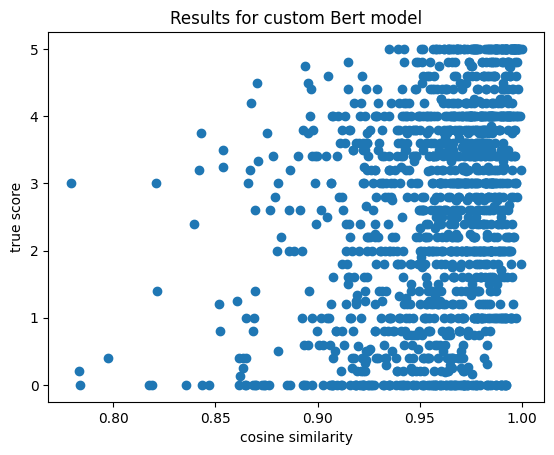

In [ ]:
# Lets visualize the data
plt.scatter(results_from_pretrained[2],results_from_pretrained[3])
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for custom Bert model")
plt.show()

In [ ]:
#Run evaluation loop with the hugging face model to chekc thta it gives the correct results
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained_hf = eval_loop(bert_hf, test_dataloader, device)

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]

In [ ]:
# Lets check the confidence interval of the correlation coefficients to check if the results of our model
# correspond to the results of the model loaded with the hugging face library
print(f'\nPearson correlation: {results_from_pretrained_hf[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained_hf[1].statistic:.3f}')
print(f" Pearson correlation {results_from_pretrained_hf[0].statistic:.3f}, confidence intervals {results_from_pretrained_hf[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_pretrained_hf[1].pvalue:.5f}")


Pearson correlation: 0.316
Spearman correlation: 0.328
 Pearson correlation 0.316, confidence intervals ConfidenceInterval(low=0.2679994871370869, high=0.363038675438626)
 Spearman Hipothesis test pvalue 0.00000


We get the correct implementation using the model from HF, so, I must have made a mistake in the debugging. If you happen to know where the error is I would really appreciate lleting me know, I am really interested in learning these subject.

On other side, notice that the Spearman p value is also very close to zero, thus, the samples hav an ordinal correlation.

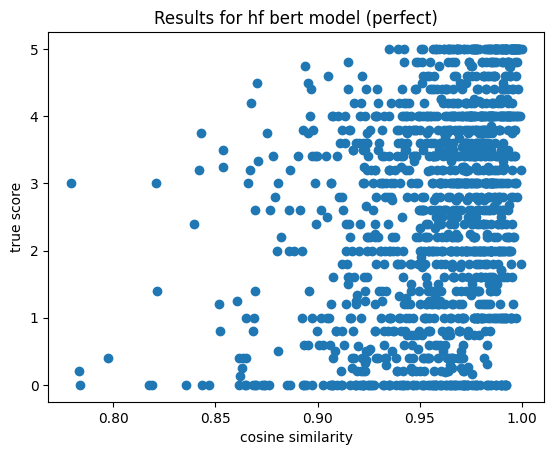

In [ ]:
# Lets visualize the data
plt.scatter(results_from_pretrained_hf[2],results_from_pretrained_hf[3])
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for hf bert model (perfect)")
plt.show()

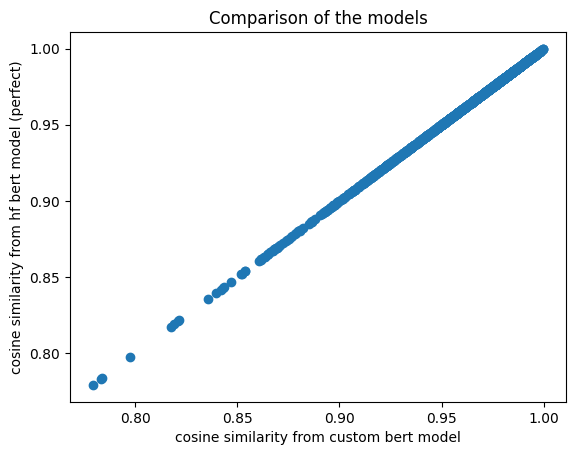

In [ ]:
# Lets compare our results with the results from the HF model, we can check that we are computing the same cosine similarities
plt.scatter(results_from_pretrained[2],results_from_pretrained_hf[2])
plt.xlabel("cosine similarity from custom bert model")
plt.ylabel("cosine similarity from hf bert model (perfect)")
plt.title("Comparison of the models")
plt.show()

Note that the coine similarity takes only positiva values, also, it only takes values greater then 0.8 for both models. This indicates that the hidden represenations are using only a small part of the laten space to represent the sentences, which in my opinion is not desirable if we want to create a rather expresive model. This phenomena has been seen in BERT models, where the embeddings are anisotropic (section 5 [SimCSE](https://arxiv.org/pdf/2104.08821.pdf)), and various methods have been proposed to diminish this effect, like using [normalizing flows over the laten space](https://lilianweng.github.io/posts/2021-05-31-contrastive/#bert-flow) or using a [subset of the PCA components of the embeddings](https://lilianweng.github.io/posts/2021-05-31-contrastive/#whitening-operation), in this assignement we will look into an alternative way of tacklig this problem which consists on using [contrastive losses](https://www.sbert.net/docs/package_reference/losses.html?highlight=contrastiveloss#contrastiveloss) to enforce the embedings to use as much space as possible, which was analyzed in the [SimCSE paper](https://arxiv.org/pdf/2104.08821.pdf).

So, even though is rather hard to imagine how the latent representations are encoding the information, from embeddings deviced for cosine simlarity search I would expect that sentences with opposite meaning are encodede in vectors with negative cosine simlairity, and sentences that are not related have close to zero cossine simlarity. Lets check if we can get that from training the Bert model for classification in the next point.

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://arxiv.org/abs/1705.02364) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

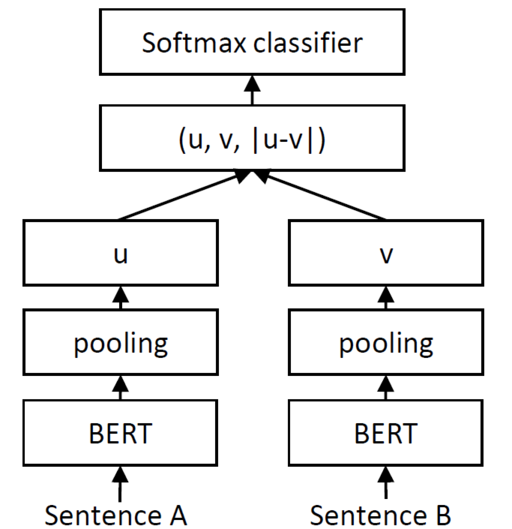

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method. Please follow the architecture illustrated in the given figure.

## Context: Sentence embeddings with BERT

The paper behind the sentence transformers library is used as an inspiration for this assignement
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf):
In that paper it is decribed three metodologies to train sentence embeddings for text similarity:
- The classifier used in the second point
- A regression problem using as objtective function the cosine similarity
- A triple training objective function that compares positve and negative pairs. It uses the euclidian distance.

In that paper is discussed that the spearman correlation coefficient is a better metric for the relation between cosine similairities and true score similairities, and the performance of the models is measured in terms of the spearman similarity * 100. (Table 1)

- They use various ways of getting the embedding out of the BERT model, these are
 - CLS token
 - Mean strategy
 - max over time of the output vectors (this one I do not fully understand)
 it is menmtioned that Mean strategy gives better results for untrained BERt models.

Another takeaways:

- They mention that the best results come from using the concatenation of features that is shown in this assignement (Table 6), that is, $(v,u,|v-u|)$.

- Also, they mention that the SentenceBert is faster than the LSTM implementation InferSent.

- The SentenceBert also provided a sota on the SentEval metric, which uses the sentence embeddings to perform various regression and classificaiont tasks, this is doe through a logistic regressor on top of the embeddings.

- The SentenceBert is trained in the SNLI dataset, and tested in STS dataset.

The setup decribed in this exercise is also described in the `Sentence-Transformers` [package](https://www.sbert.net/), which additionally proposes a metodology for training the embeddings using the cosine similarity of the embeddings as a predictor of the similarity score (regression) of  uses as simimilar setup to [train their BERT Models to get sentence embeddings design for similarity search using the cosine smilarity](https://www.sbert.net/docs/training/overview.html#loss-functions):


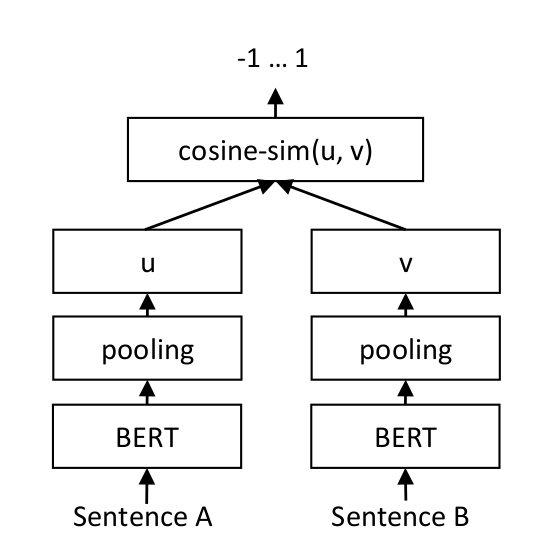



The `Sentence-Transformers` is an itneresting option to explore in the last point of the assignmente, for now lets mentions some of its functionalities:

- They provide an procedure to rank al the pairwise cosine similarities from the elemnts of a list, it is design to diminish the memory footprint and amount of computations needed to perform the ranking over all the pairs of sentences.
https://www.sbert.net/examples/applications/paraphrase-mining/README.html

- Is possible to perform both symmetric and asymmetric similarity search, in this assignement we focus on symmetric similarity search. Symmetric similairty means that both the query and the result have similar lenghts, e.g., [looking for similar questions over the Quora dataset](https://www.sbert.net/examples/applications/semantic-search/README.html#similar-questions-retrieval). On the other side, asymmetric similarityu means that the query and the result have significantly different lengst,  e.g. [looking for answer to a question](https://www.sbert.net/examples/applications/semantic-search/README.html#question-answer-retrieval). [There are models trained for both types of search](https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search).

- There are various methiods to speed up the search for similar vectors, ranging from usin [approximated Knn](https://www.sbert.net/examples/applications/semantic-search/README.html#approximate-nearest-neighbor) up to using [cross encoders](https://www.sbert.net/examples/applications/retrieve_rerank/README.html).

- The sentence transformers library also provides a fucntionallity to use [multiple GPU to compute embeddings](https://www.sbert.net/examples/applications/computing-embeddings/README.html#multi-process-multi-gpu-encoding), this I would try, however, I have no access to a multi GPU computer at the moment. It creates a [pool of process](https://github.com/UKPLab/sentence-transformers/blob/c5f93f70eca933c78695c5bc686ceda59651ae3b/sentence_transformers/SentenceTransformer.py#L229-L232) using the multiprocess library from python, and uses each process to [send the computation to each torch device](https://github.com/UKPLab/sentence-transformers/blob/c5f93f70eca933c78695c5bc686ceda59651ae3b/sentence_transformers/SentenceTransformer.py#L292-L302).


**Datasets**:
- In the previous point we used

- In this point we will use the [AllNLI dataset](https://www.sbert.net/examples/training/nli/README.html?highlight=allnli#data) which is provided by the Sentence-Transformers package, it consists of the SNLI and the MultiNLI package.

## Approach

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
# Download the data
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-01 18:54:59--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 172.67.180.145, 104.21.67.200, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|172.67.180.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-01 18:54:59--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz’

AllNLI.tsv.gz       100%[===================>]  38.90M  18.2MB/s    in 2.1s    

2023-10-01 18:55:02 (1

In [ ]:
# Read the data
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
# uncompress file to check its content
! gunzip -k AllNLI.tsv.gz
# chekc how many lines the file has
! wc -l AllNLI.tsv

981383 AllNLI.tsv


In [ ]:
# add the proper diretions to pandas so that the data can be readed
data = pd.read_csv('AllNLI.tsv.gz', compression='gzip', delimiter='\t', quoting=3)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981382 entries, 0 to 981381
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   split      981382 non-null  object
 1   dataset    981382 non-null  object
 2   filename   981382 non-null  object
 3   sentence1  981382 non-null  object
 4   sentence2  981336 non-null  object
 5   label      981382 non-null  object
dtypes: object(6)
memory usage: 44.9+ MB


In [ ]:
# Chekc how many values we have in the column split
data['split'].value_counts()

train    942069
dev       19657
test      19656
Name: split, dtype: int64

In [ ]:
# Check how many labels we have
data['label'].value_counts()

entailment       327954
contradiction    327058
neutral          326370
Name: label, dtype: int64

In [ ]:
# Lets create the functions that load and tokenize the dataset
def transform_into_classes(row):
  """
  Function to encode the labels numerically:
    contradiction -> 0
    neural -> 1
    entailtment -> 2
  This is the expect encodding so that the CrossEntropyLoss can be used to train the multilabel
  classifier: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

  """
  if row['label']== 'contradiction':
    return 0
  elif row['label']== 'neutral':
    return 1
  else:
    return 2


def load_nli_dataset(file_name, get_num_encoding_of_label=transform_into_classes):
  #TODO: add code to load NLI dataset in required format
  #nli_samples = {'train': []}
  #return nli_samples
  """
  Load data using pandas and create a dictionary with the sentences

  Args:
  file_name: string with tha name of the file to load
  get_num_encoding_of_label: callable that recieves a row of a dataframe and returns an numeric encoding
    for the column 'label'

  Returns:
  dictionary with the data, the dicitonary has the following form:
  dict['test']: list of values in the test split, ech element consists of a list of three values
    "sentence1","sentence2","label_num"
  dict['train']: list of values in the train split, ech element consists of a list of three values
    "sentence1","sentence2","label_num"
  dict['dev']: list of values in the dev split, ech element consists of a list of three values
    "sentence1","sentence2","label_num"
  """
  data = pd.read_csv(file_name, delimiter='\t',quoting=3)
  data['label_num'] = data.apply(get_num_encoding_of_label,axis=1)
  nli_samples = {'test': data[data['split'] == 'test'][["sentence1","sentence2","label_num"]].values,
                 'train': data[data['split'] == 'train'][["sentence1","sentence2","label_num"]].values,
                 'dev': data[data['split'] == 'dev'][["sentence1","sentence2","label_num"]].values
                 }
  return nli_samples


def tokenize_sentence_pair_nli_dataset(dataset, tokenizer, max_length=512):
  """
  Tokenize the sentences in the dataset

  Returns:
    tokenized_dataset: List[Tuple[BatchEncoding,BatchEncoding]]

  The tokenizer returns a BatchEncoding with the following information
  https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__.returns
  """
  tokenized_dataset = []
  for sentence1, sentence2, label in dataset:
    tokenized_dataset.append(
        {
        "token1":tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=max_length),
        "token2":tokenizer(sentence2, return_tensors='pt', padding='max_length', max_length=max_length),
        "label": label
        }
      )
  return tokenized_dataset


In [ ]:
# Lets laod the tokenizer to compute the input to the models
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
#INFO: load dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
tokenized_train = tokenize_sentence_pair_nli_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

In [ ]:
# Check that the elements have the expeted dimensions i.e. size(1) == 128
for element in tokenized_train:
  if element['token2']['attention_mask'].size(1) != 128:
    print(element['token1']['input_ids'].size(1))
    break

In [ ]:
# I want to check that the model from HF works with an amount of tokens les than the max amount of tokens of the model
MODEL_NAME = 'prajjwal1/bert-tiny'
bert_hf = AutoModel.from_pretrained(MODEL_NAME)
output = bert_hf(**tokenized_train[0]['token1'])
type(output[1])

torch.Tensor

In [ ]:
# Lets check one hidden vector
output[1]

tensor([[-1.0000,  0.0180, -0.9972,  0.9531, -0.9980,  0.3693, -0.9984, -0.8313,
          0.0203, -0.0029, -0.9637, -0.0339, -0.0528,  1.0000, -0.9860, -0.3185,
          0.9518,  0.0780, -0.9818,  0.9860,  0.9391,  0.0309,  0.9803,  0.7926,
         -0.9996, -0.0849, -1.0000,  0.9701,  0.8760,  0.0778, -0.0415, -0.2042,
         -0.9808,  0.3081,  0.9774,  1.0000, -0.5059,  0.0931,  0.8412, -0.9996,
          0.9467,  0.9745, -0.9991,  0.9638, -1.0000, -0.0757, -0.9999,  0.9998,
          0.7250,  0.9709,  0.9388, -0.4327, -0.0479,  0.9988,  0.9992,  1.0000,
         -0.9998, -0.9129,  0.8547, -0.9945, -0.0675,  0.2134,  0.7749,  0.9268,
          0.6269, -1.0000, -0.3480, -0.9577,  0.5373,  0.4401,  0.9952,  0.1453,
         -0.9988, -0.1618,  0.4489, -0.9534, -0.2118,  0.1576, -0.9403, -0.0633,
         -0.7592,  0.0316, -0.3420, -0.9999,  0.9998, -0.9927,  0.9297, -0.7726,
         -0.8128,  0.7865, -0.9872,  0.9923, -0.5125,  0.9925,  0.2910,  0.2277,
         -0.9191, -0.9653, -

In [ ]:
# now I want to check that the model implemented in this notebook works with inputs lesss than the max_sequence_len
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
               }
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
output = bert(**tokenized_train[0]['token2'])

# Get the pooled output
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


In [ ]:
# now we can implement the function that generates the DataLoader form pytorch
def collate_fn_labels(batch):
  """
  Provide the correct dimensions to the tensors inside the batches of DataLoader

  Args:
  batch: iterable that generates enrties from the dataset using the next(dataset)
    function
  """

  input_ids_1 = torch.stack([item['token1']['input_ids'][0] for item in batch])
  attention_mask_1 = torch.stack([item['token1']['attention_mask'][0] for item in batch])

  input_ids_2 = torch.stack([item['token2']['input_ids'][0] for item in batch])
  attention_mask_2 = torch.stack([item['token2']['attention_mask'][0] for item in batch])

  labels = torch.stack([torch.tensor(item['label']) for item in batch])

  return {"input_ids_1": input_ids_1, "attention_mask_1" : attention_mask_1,
          "input_ids_2":input_ids_2, "attention_mask_2" : attention_mask_2,
          "labels" : labels}

In [ ]:
# Lets compute the Dataloader
batch_size = 3
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_labels)

In [ ]:
# check that we can iterate over the DataLoader
l = 0
for i, batch in enumerate(train_dataloader):
  l += 1
l

16667

In [ ]:
# LEts compute a small dataloader for testing
tokenized_train_small = tokenize_sentence_pair_nli_dataset(nli_dataset['train'][:100], tokenizer, max_length=128)
# Lets compute the Dataloader
batch_size = 3
train_dataloader_small = get_dataloader(tokenized_train_small, batch_size=batch_size, shuffle=True, collate_fn= collate_fn_labels)

In [ ]:
# Lets check the ourput of the test_dataloader
# Get the first item from the DataLoader
for i, batch in enumerate(train_dataloader_small):
    if i == 0:
        first_batch = batch
        break

print(type(first_batch['input_ids_1']))

<class 'torch.Tensor'>


In [ ]:
# Check that we get the correct size for the tensors
print(first_batch['input_ids_1'].shape)
print(first_batch['attention_mask_1'].shape)
print(first_batch['labels'].shape)

torch.Size([3, 128])
torch.Size([3, 128])
torch.Size([3])


In [ ]:
####### Define the train loop

# TODO: Add the option for a periodic eval on dev test can be added (validation_dataloader)

def train_loop(model, optimizer, train_dataloader, num_epochs, device, verbose= False):
    """
    Train the model using and optimizer and a given number of epochs,

    Args:
    model: BertClassified model
    optimizer: Pytorch optimizer
    train_dataloader: DataLoader instance
    num_epocs: int indicating the numebr of epochs
    device: device to use in the computations
    verbose: Bool that tells if information needs to be printed

    """
    #move the model to the device
    model = model.to(device)
    # Set the model in training mode
    model.train()
    # Train
    pbar_epochs = tqdm(total = num_epochs, leave=True, display=verbose, position=0, desc='Iteration over epochs')
    for epoch in range(num_epochs):
        total_loss = 0
        pbar_batch = tqdm(total = len(train_dataloader), leave=False, display=verbose, position=1, desc='Iteration over batches')
        for step, batch in enumerate(train_dataloader):
            # clear previous gradients
            optimizer.zero_grad()
            # move batch to device
            batch = { key : value.to(device) for key,value in batch.items()}
            # forward pass
            # passs the information properly such that the labels are passed properly
            if "labels" not in batch or batch['labels'] is None:
              raise ValueError(f"To train a classifier your DataLoader must provide batches with labels, instead is has the keys {batch.keys()}")
            # get the loss
            _, loss = model(**batch)
            total_loss += loss.item()
            # perform a backward pass (backpropagation)
            loss.backward()
            # Update the parameters
            optimizer.step()
            pbar_batch.update(1)
        pbar_batch.close()
        # print information aboutn the progress
        avg_train_loss = total_loss / len(train_dataloader)
        pbar_epochs.set_description(f'Average training loss: {avg_train_loss}')
        pbar_epochs.update(1)
    pbar_epochs.set_description(f'Training Finisehd!!: Average training loss: {avg_train_loss}')
    pbar_epochs.close()
    # Set model to eval mode once it is trained
    model.eval()

In [ ]:
#### Define the BertClassifier class
class BertClassifier(nn.Module):
    """
    Siamese BERT encoder design to train a classifier on the AllNLI dataset,
    it follows the architecture of the classifier exposed in the Sentence Transformert paper
    https://arxiv.org/pdf/1908.10084.pdf

    """

    def __init__(self,bert_encoder,num_classes):
      """

      Args:
      bert_encoder: Bert model implemented in pytorch
      num_classes: integer indicating the amount of classes in the dataset

      """
      super(BertClassifier, self).__init__()
      # Set the Bert encoder
      self.bert_encoder =  bert_encoder
      self.num_classes = num_classes
      # Create the linear layer of a softmax classifier, we use a simple one linear layer
      # for future references we can look into more complex architectures, like ones exposed in https://arxiv.org/pdf/1705.02364.pdf.
      # The classifier recieves a vector of size self.bert_encoder.config.hidden_size*3 and returns a vecotr of size num_classes
      self.classifier_layer = nn.Linear(self.bert_encoder.config.hidden_size*3 , self.num_classes)
      # Set the loss for a multilabel classifier
      # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
      self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, labels = None):
        """
        Compute the CroosEntropy losss and the label of the mattching

        Args:
        input_ids_1: tensor with shape (batch_size, sequence_len)
        attention_mask_1: tensor with shape (batch_size, sequence_len)
        input_ids_2: tensor with shape (batch_size, sequence_len)
        attention_mask_2: tensor with shape (batch_size, sequence_len)
        labels: tesor with size (batch_size) that contains the labels, the format
          for the labels is [l0,l1,...,ld] with each li inside [0,C) with C the amount of classes

        Returns:
        result[0]: torch tensor of size (batch_size) with the predictions of the labels
        result[1]: if there are labels provided then this is the loss computed using the CrossEntropyLoss,
          else, it does not exists
        """
        # Compute vector representation of the first sentence
        outputs_1 = self.bert_encoder(input_ids=input_ids_1, attention_mask=attention_mask_1)
        last_hidden_state_1 = outputs_1[1]
        # Compute vector representation of the second sentence
        outputs_2 = self.bert_encoder(input_ids=input_ids_2, attention_mask=attention_mask_2)
        last_hidden_state_2 = outputs_2[1]
        # concatenate the outputs as (u,v, |u-v|) where |u-v| correspondos to the absolute element-wise
        # difference of u and v, as exosed in page 3 of https://arxiv.org/pdf/1705.02364.pdf
        # This vector has shape (batch_size, hidden_dim*3)
        complete_vector_representation = torch.cat((last_hidden_state_1,
                                    last_hidden_state_2,
                                    torch.abs(last_hidden_state_1 - last_hidden_state_2)),
                                    dim=-1
                                  )
        # Compute the logist that gives us the labels
        # Apply one linear representation to get labels
        logits = self.classifier_layer(complete_vector_representation)
        # logits has a shape of (batch_size,num_classes)
        # Get the predicted class
        predicted_label = torch.argmax(logits, dim= -1)
        result = (predicted_label, )
        if labels is not None:
          # Compute the CrossEntropyLoss.
          # - we can provide unnormalized logits to the loss function
          # - the labels must have shape (batch_size) and be an integer number in the range [0,C)
          # with C the amoun of classes
          loss = self.loss_fn(logits, labels)
          result = (predicted_label, loss)
        return result

In [ ]:
# Check that the Bert Calssifier works
# I want to check that the model from HF works with an amount of tokens les than the max amount of tokens
MODEL_NAME = 'prajjwal1/bert-tiny'
bert_hf = AutoModel.from_pretrained(MODEL_NAME)
n_classes = 3
bert_classifier_hf = BertClassifier(bert_hf,n_classes)

In [ ]:
first_batch.keys()

dict_keys(['input_ids_1', 'attention_mask_1', 'input_ids_2', 'attention_mask_2', 'labels'])

In [ ]:
# Check that the hugging face model works inside the classifier
output = bert_classifier_hf(**first_batch)
output

(tensor([1, 2, 1]), tensor(1.1606, grad_fn=<NllLossBackward0>))

In [ ]:
# Chekc that the BertClassifier works
# I want to check that the Bert model implemented in this notebooks can be used insdie this classifier
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
              }
bert = Bert(bert_config).load_model('bert_tiny.bin')
n_classes = 3
bert_classifier = BertClassifier(bert,n_classes)

In [ ]:
# Check that the implemented model works inside the classifier
output = bert_classifier(**first_batch)
output

(tensor([2, 2, 0]), tensor(0.8837, grad_fn=<NllLossBackward0>))

In [ ]:
# Get a small sample to test the implementation
tokenized_train_small = tokenize_sentence_pair_nli_dataset(nli_dataset['train'][:100], tokenizer, max_length=128,)
# Lets compute the Dataloader for a small sample
train_dataloader_small = get_dataloader(tokenized_train_small, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_labels)

In [ ]:
# Now we are going to check that the training does not fail
# Parameters
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
              }
bert_path = 'bert_tiny.bin'
#Load the Bert model
bert = Bert(bert_config).load_model(bert_path)
# create the BertClassifier
bert_classifier = BertClassifier(bert,num_labels)
#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader_small, num_epochs, device, verbose = True)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/34 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/34 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
# TODO: find out how to vase a load a custom model in pytorch. I have not been able to save and laod back again the
# classifiers nor the models trained using contrastive loss. I will save the parameters of the model to check later
# if I can figure this out
# TODO: find how to save and load the model
torch.save(bert_classifier.state_dict(), 'untrained_bert_classifier.pth')

[('',
  BertClassifier(
    (bert_encoder): Bert(
      (embeddings): ModuleDict(
        (token): Embedding(30522, 128, padding_idx=0)
        (position): Embedding(512, 128)
        (token_type): Embedding(2, 128)
      )
      (ln): LayerNorm()
      (dropout_embedding): Dropout(p=0.1, inplace=False)
      (layers): ModuleList(
        (0-1): 2 x Layer(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (dropout_attention): Dropout(p=0.1, inplace=False)
          (attn_out): Linear(in_features=128, out_features=128, bias=True)
          (dropout_hidden): Dropout(p=0.1, inplace=False)
          (ln1): LayerNorm()
          (mlp): MLP(
            (dense_expansion): Linear(in_features=128, out_features=512, bias=True)
            (dense_contraction): Linear(in_features=512, out_features=128, bias=True)
          )


### Results for the implemented model

In [ ]:
# Now that it works we can perform the training with 50000 samples per epoch as established in the problem

# Parameters
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
              }
bert_path = 'bert_tiny.bin'
#Load the Bert model
bert = Bert(bert_config).load_model(bert_path)
# create the BertClassifier
bert_classifier = BertClassifier(bert,num_labels)

In [ ]:
#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')
# Get a small sample to check it works
tokenized_train = tokenize_sentence_pair_nli_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128,)
# Lets compute the Dataloader for a small sample
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True, collate_fn= collate_fn_labels)

In [ ]:
# Create an optimizer and train the bert model implemented
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device, verbose = True)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/6250 [00:00<?, ?it/s]

In [ ]:
# TODO: find how to save and load the model
torch.save(bert_classifier.state_dict(), 'bert_classifier.pth')

In [ ]:
results_from_classification = eval_loop(bert_classifier.bert_encoder, test_dataloader, device)
print(f'\nPearson correlation: {results_from_classification[0].statistic:.4f}\nSpearman correlation: {results_from_classification[1].statistic:.4f}')

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]


Pearson correlation: 0.5059
Spearman correlation: 0.5272


In [ ]:
# Notice that the the original bert model used as a parameter to the bertclassifier was modified, cause python passes elements by reference by default
results_from_classification_test = eval_loop(bert, test_dataloader, device)
print(f'\nPearson correlation: {results_from_classification_test[0].statistic:.4f}\nSpearman correlation: {results_from_classification_test[1].statistic:.4f}')

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]


Pearson correlation: 0.5059
Spearman correlation: 0.5272


In [ ]:
# Lets check the confidence interval of the correlation coefficients to check if the results of our model
# correspond to the results expected
print(f" Pearson correlation {results_from_classification[0].statistic:.3f}, confidence intervals {results_from_classification[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_classification[1].pvalue:.8f}")

 Pearson correlation 0.506, confidence intervals ConfidenceInterval(low=0.46549739196647416, high=0.5441136264617845)
 Spearman Hipothesis test pvalue 0.00000000


We can see that the correlation has increased more than expect using the implemented model, also, the 95% confidence intervals tell us that the Pearson correlation has actually increased instead of just getting more 'random'. Additionally, the p value for the Spearman test is very low, indicating that the data has some type of ordinal correlation.

In [ ]:
print("Results without trainig")
print(f" Pearson correlation {results_from_pretrained[0].statistic:.3f}, confidence intervals {results_from_pretrained[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_pretrained[1].pvalue:.8f}")

Results without trainig
 Pearson correlation 0.316, confidence intervals ConfidenceInterval(low=0.26799948298296195, high=0.36303867155291647)
 Spearman Hipothesis test pvalue 0.00000000


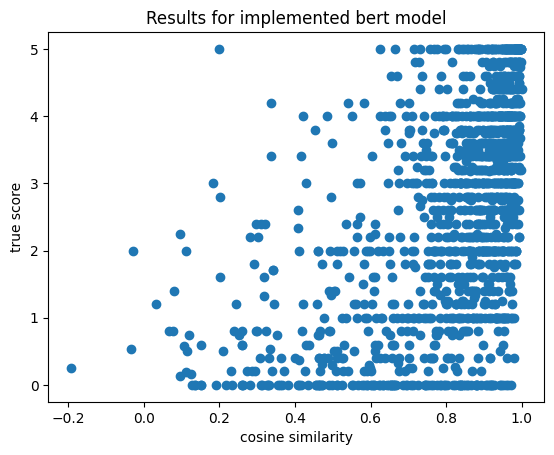

In [ ]:
# Lets visualize the data and compare it with the
plt.scatter(results_from_classification[2],results_from_classification[3])
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for implemented bert model")
plt.show()

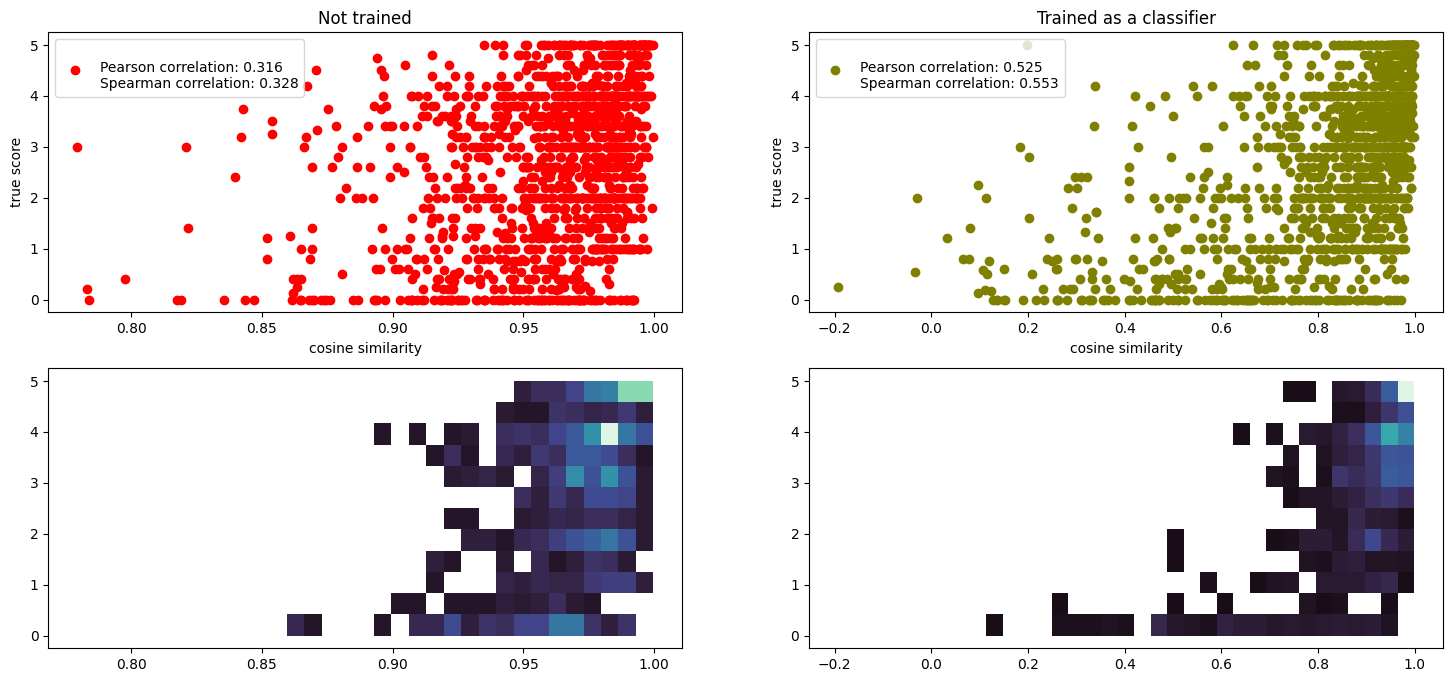

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2,2, figsize = (18,8))

# Plot data on each subplot
axs[0][0].scatter(results_from_pretrained[2],results_from_pretrained[3], c='red',
            label = f'\nPearson correlation: {results_from_pretrained[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained[1].statistic:.3f}' )
axs[0][1].scatter(results_from_classification[2],results_from_classification[3], c = 'olive',
            label=f'\nPearson correlation: {results_from_classification[0].statistic:.3f}\nSpearman correlation: {results_from_classification[1].statistic:.3f}')
# Plot histograms to check that the lower triangular part of the
sns.histplot(x=results_from_pretrained[2],y=results_from_pretrained[3],pthresh=.01, cmap="mako", ax= axs[1][0])
sns.histplot(x=results_from_classification[2],y=results_from_classification[3],pthresh=.01, cmap="mako", ax= axs[1][1])

# Set x and y-axis labels for each subplot
axs[0][0].set_xlabel('cosine similarity')
axs[0][0].set_ylabel('true score')

axs[0][1].set_xlabel('cosine similarity')
axs[0][1].set_ylabel('true score')

# Set title for each subplot
axs[0][0].set_title('Not trained')
axs[0][1].set_title('Trained as a classifier')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')

# Display the figure with subplots
plt.show()

1. The range of the values of the cosine simliarity has improved, meaning that the embeddings are using more space to represent the semantic similarity.
2. There are a few no pairs of vectors with negative cosine similarity, this means that the embneddings are mostly usin half the latent space to represent the sentences.
3. The cosine simlarity is not a good perdictor for the score, because there are a fair amount of vectors taking all the possible values of the score in the region of high cosine similarity. So, a predictor of the score under giving the cosien simlairyt would at best know when the score is low (when the cosine similarity is lower than 0.6), but could not resolve if a pair of vectors a a high score based on the cosine similarty. This happens because Bert models tend to have an anisotropic embeddings distribution (do not use unformly the latent space), thus, is necessary to
4. To asses the performan of a model that predicts the score based on the cosine simlairyt I would add an assymetric measure of correltion between the cosine similarities and the scores, for example the PPS (predictive power score), the conditional entropy (or the conditional entropy divideed by the entropy), the [CHATTERJEE correlation coefficient](https://arxiv.org/pdf/1909.10140.pdf), or any other . Akaik these are called association coefficients, instead, cause they measure the strengh of a relation between X and Y, while correlation coefficients measures whether two samples are related, wihout regard to which depends on which.
 I would do this because we could get a high correlation and have that the cosine similarity is useless, for example, if scores were located over a vertical line with respect to the cosine similarity, in this case we would get a high pearson and spearman correaltion because those are [symmetric measures of correlation](https://www.phind.com/search?cache=pyuaymrw0qhqoianpkvdugb6), but we will have a useless cosinse simlarity because we would not be able to tell appart different scores using only the cosine similarities.
 The Spearman correlation is the standard metric to asses the quality of embeddings while using the cosine similarity ([Sentence Transformer paper](https://arxiv.org/pdf/1908.10084.pdf)), however, I believe that the Chatterje statistic could be a better indicator of wheter we can predict the similarity score given the cosine similarity, hopefully I will have some time to test this.

 I have a huntch that the increase of the correlation coefficient is not comming from an improvement of the predictive power of the cosine similarity, but rather as the fourt case ($x_4$) of the [Ascombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet), where we get a high correlation coefficient due to the fact that both Pearson and Spearman correlation are impacted by exteme values (the values close to the x axis that are close to 0).

5.We are using a linear transformation over the the hidden represenations to calssifiy the sentences, thus, we could expect that linear characteristics of the hidden vectors are used to classify them. However, we are not using a explicitly the cosine similarity to define the loss of the classifier, thus, I would not expect that the classifier on top of the hidden dimension would be able to fully use the cosine similarity, let me explain why. Our classifier looks like
$$ \text{argmax} \{A \cdot (x,y,|x-y|)^T + b\}, A \in M_{3,3*\text{hidden_dim}}, b \in M_{3,1}, $$
so, our classificator consists of three perceptrons, and it is known that [perceptrons are not universal classifiers](https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/#Perceptron). Moreover, the maps
  - $x \mapsto \|x\|$   
  - $ \phi: \mathbb{R}^{2*\text{hidden_dim}} \to \mathbb{R},\;  \phi(x,y) \mapsto \sum_{i < n} x_i y_i$,

  are not linear, so, since the cosine similarity is defined as
  $$  cos(x,y) = \frac{x \cdot y}{\| x \| \|y \|}, $$  
  I would not expect the softmax classifier to learn to use the cosine similarity to classify the pairs. Rather, I would expect it to perform something like a PCA analysis of all the hidden representations of the sentences couple with a tunning of the hidden representations, by this I mean, it will find three vectors $v_0, v_1, v_2 \in \mathbb{R}^{2*\text{hidden_dim}}$ such that
  - $cos(v_0, (x,y,|x-y|)^T) + b_0$ would be the score assigned to $x,y$ being semantically similar,
  - $cos(v_1, (x,y,|x-y|)^T) + b_1$ would be the score assigned to $x,y$ being semantically unrelated,
  - $cos(v_2, (x,y,|x-y|)^T) + b_2$ would be the score assigned to $x,y$ being semantically opposed,

  and $A(i,j) = v_i(j)$, $b(i) = b_i$. So, we instead of computing the cosine similarity of $x,y$ we would find standard vectors to to which se compute the cosine simlarity. In this case I would understand $v_i$ as the components with most variance over the set of all possible sets of embeddings, I say "understand" because the computations are not precesile those of doing a PCA analysis over those vectors but the idea of finding vectors of most variance with respect to the semantic representation. Accordign to the [ablation study on the SBERT](https://arxiv.org/pdf/1908.10084.pdf) the term $|u-v|$ makes the embedings of similar sentences to be close and the embedings of disimilar sentences to be far appart.

  On other side, we know that the shallowest NN that is a universal approximator is a [two layer NN](https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/#Universal_Approximation_Theorem), thus, if I were to use a NN to classify vectors according to similarity adn expect to ti use the cosina similarity as a predictor I would at lest use a two layer NN. However, this would not guaranty that the NN is in fact using the cosine similarity to capture the semantic relations, it could be using other possible non linear features of the vectors.

### Results for the loaded model

In [ ]:
# Parameters
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
              }
bert_path = 'bert_tiny.bin'

#Load the Bert model using the HF interface
bert_hf = AutoModel.from_pretrained(model_name)
# create the BertClassifier
bert_classifier_hf = BertClassifier(bert_hf,num_labels)

In [ ]:
# Create an optimizer and train the bert model implemented
optimizer_hf = AdamW(bert_classifier_hf.parameters(), lr=5e-5)
train_loop(bert_classifier_hf, optimizer_hf, train_dataloader, num_epochs, device, verbose = True, n_messages_per_epoch = 30)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/6250 [00:00<?, ?it/s]

In [ ]:
results_from_classification_hf = eval_loop(bert_classifier_hf.bert_encoder, test_dataloader, device)
print(f'\nPearson correlation: {results_from_classification_hf[0].statistic:.4f}\nSpearman correlation: {results_from_classification_hf[1].statistic:.4f}')

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]


Pearson correlation: 0.4898
Spearman correlation: 0.5279


In [ ]:
# Notice that the the original bert model used as a parameter to the bertclassifier was modified, cause python passes elements by reference by default
results_from_classification_test_hf = eval_loop(bert_hf, test_dataloader, device)
print(f'\nPearson correlation: {results_from_classification_test_hf[0].statistic:.4f}\nSpearman correlation: {results_from_classification_test_hf[1].statistic:.4f}')

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]


Pearson correlation: 0.4898
Spearman correlation: 0.5279


In [ ]:
# Lets check the confidence interval of the correlation coefficients to check if the results of our model
# correspond to the results expected
print(f" Pearson correlation {results_from_classification_hf[0].statistic:.3f}, confidence intervals {results_from_classification_hf[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_classification_hf[1].pvalue:.8f}")

 Pearson correlation 0.490, confidence intervals ConfidenceInterval(low=0.4486448551998667, high=0.5289430720318855)
 Spearman Hipothesis test pvalue 0.00000000


We can see that the correlation has increased much more than expect using the implemented model, also, the 95% confidence intervals tell us that the Pearson correlation has actually increased instead of just getting more 'random'. Additionally, the p value for the Spearman test is very low, indicating that the data has some type of ordinal correlation.

In [ ]:
print("Results without trainig")
print(f" Pearson correlation {results_from_pretrained_hf[0].statistic:.3f}, confidence intervals {results_from_pretrained_hf[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_pretrained_hf[1].pvalue:.8f}")

Results without trainig
 Pearson correlation 0.316, confidence intervals ConfidenceInterval(low=0.2679994871370869, high=0.363038675438626)
 Spearman Hipothesis test pvalue 0.00000000


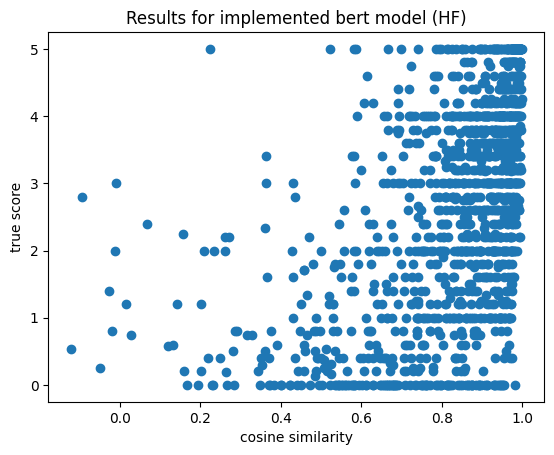

In [ ]:
# Lets visualize the data and compare it with the
plt.scatter(results_from_classification_hf[2],results_from_classification_hf[3])
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for implemented bert model (HF)")
plt.show()

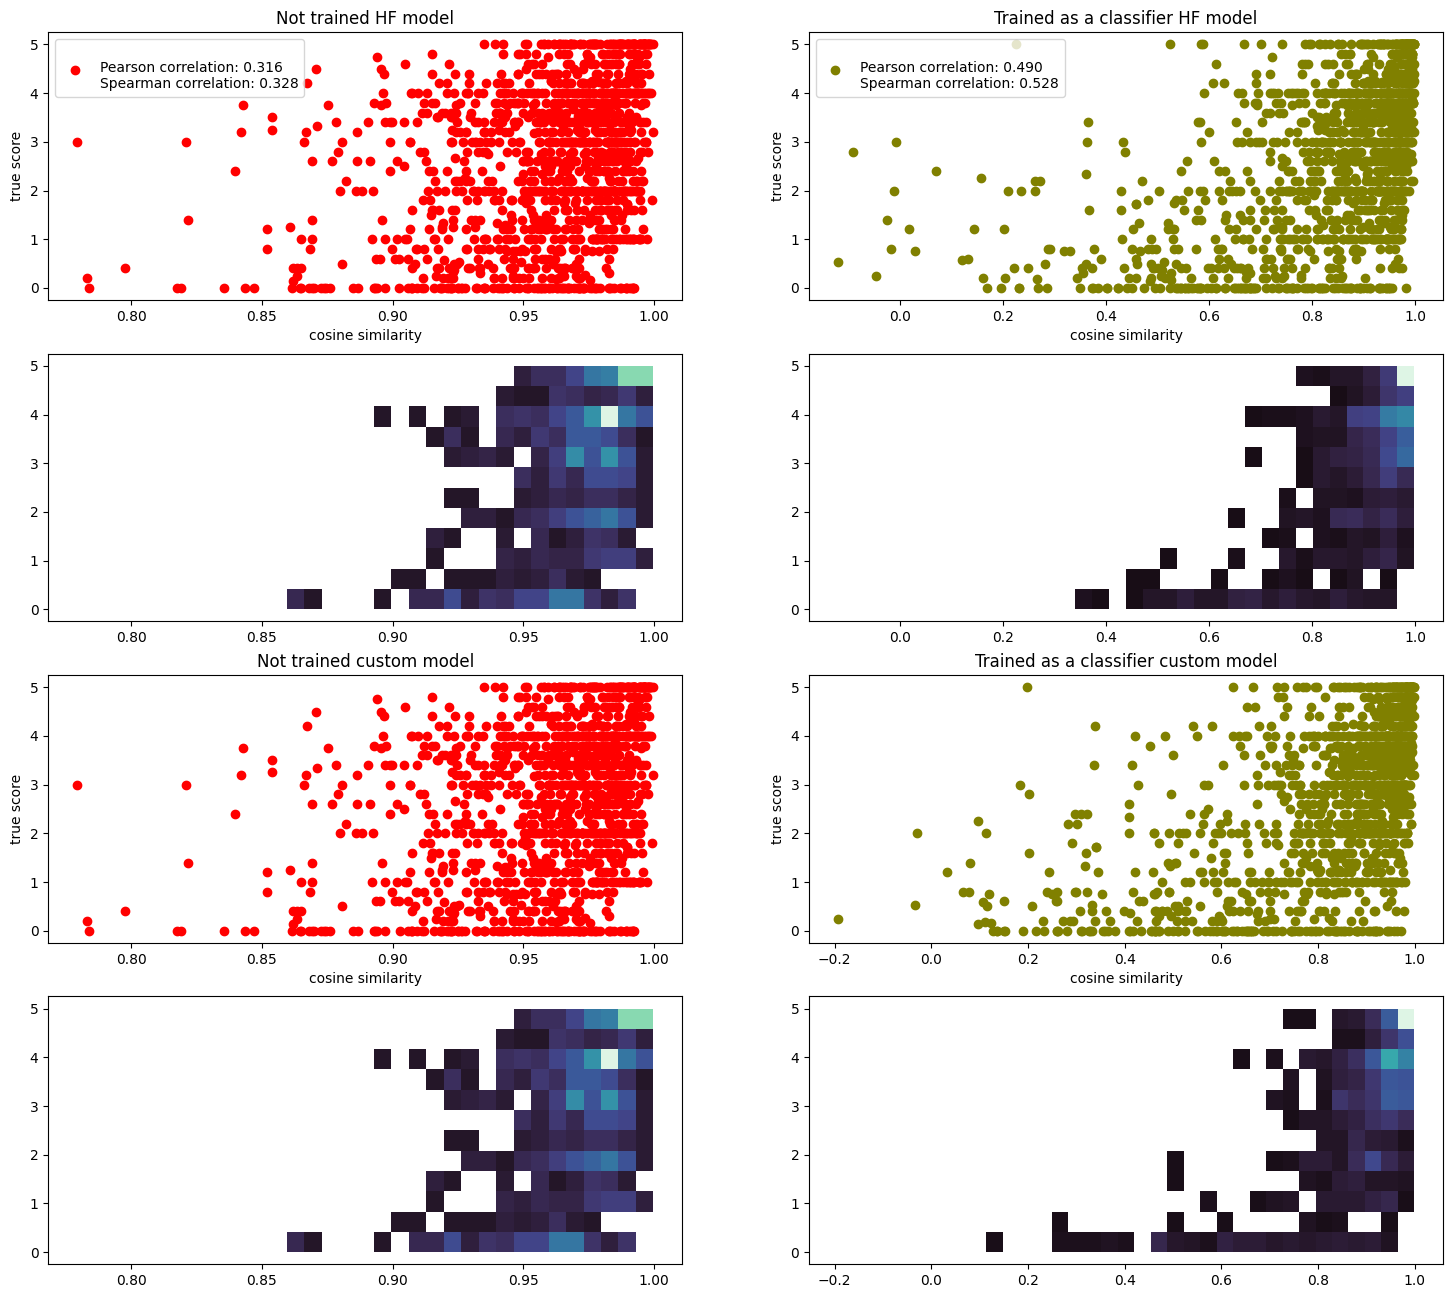

In [ ]:
# Create a figure and a set of subplots
fig, axs= plt.subplots(4,2, figsize = (18,16))

# Plot data on each subplot
axs[0][0].scatter(results_from_pretrained_hf[2],results_from_pretrained_hf[3], c='red',
            label = f'\nPearson correlation: {results_from_pretrained_hf[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained_hf[1].statistic:.3f}' )
axs[0][1].scatter(results_from_classification_hf[2],results_from_classification_hf[3], c = 'olive',
            label=f'\nPearson correlation: {results_from_classification_hf[0].statistic:.3f}\nSpearman correlation: {results_from_classification_hf[1].statistic:.3f}')
# Plot histograms to check that the lower triangular part of the
sns.histplot(x=results_from_pretrained_hf[2],y=results_from_pretrained_hf[3],pthresh=.1, cmap="mako", ax= axs[1][0])
sns.histplot(x=results_from_classification_hf[2],y=results_from_classification_hf[3],pthresh=.1, cmap="mako", ax= axs[1][1])

# Set x and y-axis labels for each subplot
axs[0][0].set_xlabel('cosine similarity')
axs[0][0].set_ylabel('true score')

axs[0][1].set_xlabel('cosine similarity')
axs[0][1].set_ylabel('true score')

# Set title for each subplot
axs[0][0].set_title('Not trained HF model')
axs[0][1].set_title('Trained as a classifier HF model')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')


# Plot data on each subplot
axs[2][0].scatter(results_from_pretrained[2],results_from_pretrained[3], c='red',
            label = f'\nPearson correlation: {results_from_pretrained[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained[1].statistic:.3f}' )
axs[2][1].scatter(results_from_classification[2],results_from_classification[3], c = 'olive',
            label=f'\nPearson correlation: {results_from_classification[0].statistic:.3f}\nSpearman correlation: {results_from_classification[1].statistic:.3f}')
# Plot histograms to check that the lower triangular part of the
sns.histplot(x=results_from_pretrained[2],y=results_from_pretrained[3],pthresh=.1, cmap="mako", ax= axs[3][0])
sns.histplot(x=results_from_classification[2],y=results_from_classification[3],pthresh=.1, cmap="mako", ax= axs[3][1])

# Set x and y-axis labels for each subplot
axs[2][0].set_xlabel('cosine similarity')
axs[2][0].set_ylabel('true score')

axs[2][1].set_xlabel('cosine similarity')
axs[2][1].set_ylabel('true score')

# Set title for each subplot
axs[2][0].set_title('Not trained custom model')
axs[2][1].set_title('Trained as a classifier custom model')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')

# Display the figure with subplots
plt.show()


I am not sure why i am getting different resutls from trainig the custom model and trainig the model model laoded with the HF library, I balieve the differences could be in the state of the random generators and the random effect added to the trainig by the dropout, however, I might be wrong.

We can see that both models have increase their usage of the latent space such that the cosine similarity can take negative values, this is good sign. However, we are still getting a fair ammount of pairs of vectors concentrated in sections with high cosine similarity and taking all types of scores, and this means that the cosine similarity is still not a good predictor of the score. Lets see what happen is we use a contastive loss that explicitly uses thge coside similarity.

**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

## Context: Contrastive learning

Contrastive learning implies taking into account that we want to take some poinsts close and other far away, so that we can perform semantic search using the similarity score. So, ins simple words, we provide a loss functions that favors a distribution of the embedings that make sence for our purpose, i.e. to perdict the semantic similarity using the normalized inner product of vectors.


 Most of the results and explanations are taken from [Lilian Weng blog](https://lilianweng.github.io/posts/2021-05-31-contrastive/), which has a great review on contrastive learning, in particular, I focusde on the definition of [contrastive training objectives](https://lilianweng.github.io/posts/2021-05-31-contrastive/#contrastive-training-objectives) and [embeddings for NLP](https://lilianweng.github.io/posts/2021-05-31-contrastive/#language-sentence-embedding).


**Description of the NLI datase**:
In NLI datasets, given one premise, annotators are required to manually write one sentence that is absolutely true (entailment), one that might be true (neutral), and one that is definitely false (contradiction).
Therefore, for each premise and its entailment hypothesis, there is an accompanying contradiction
hypothesis.


- Simple Contrastive Learning of Sentence Embeddings: https://arxiv.org/pdf/2104.08821.pdf
 - **Dataset augmentation**: we can turn any element in the batch as a negative element for the others, which gives  a cross-entropy objective with in-batch negatives. The loss functions that take many forms, for example
  - Let $\mathbf{h}_i$ and $\mathbf{h}_i^{+}$denote the representations of $x_i$ and $x_i^{+}$, the training objective for $\left(x_i, x_i^{+}\right)$with a mini-batch of $N$ pairs is:
  $$
  -\log \frac{e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_i^{+}\right) / \tau}}{\sum_{j=1}^N\left(e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_j^{+}\right) / \tau}+\alpha^{\mathbb{1}_i^j} e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_j^{-}\right) / \tau}\right)}
  $$
  where $\mathbb{1}_i^j \in\{0,1\}$ is an indicator that equals 1 if and only if $i=j$.
  - Formally, we extend $\left(x_i, x_i^{+}\right)$to $\left(x_i, x_i^{+}, x_i^{-}\right)$, where $x_i$ is the premise, $x_i^{+}$and $x_i^{-}$are entailment and contradiction hypotheses. The training objective $\ell_i$ is then defined by ( $N$ is mini-batch size):
  $$
  -\log \frac{e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_i^{+}\right) / \tau}}{\sum_{j=1}^N\left(e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_j^{+}\right) / \tau}+e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_j^{-}\right) / \tau}\right)} .
  $$
  - Use only the negative associated to the vecotr $x_i$, to differentiate it from the other in batch samples.
  $$
  -\log \frac{e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_i^{+}\right) / \tau}}{\sum_{j=1}^N\left(e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_j^{+}\right) / \tau}+\alpha^{\mathbb{1}_i^j} e^{\operatorname{sim}\left(\mathbf{h}_i, \mathbf{h}_j^{-}\right) / \tau}\right)}
  $$
  where $\mathbb{1}_i^j \in\{0,1\}$ is an indicator that equals 1 if and only if $i=j$.
  We train SimCSE with different
 - Take aways from that approach:
    - Taking neutral elements as hard negatives do not add performance to the model.
    - The contrastive learning diminishes the anisotropy of the embeddings, which is good for semantic search over the latent space. Also, the BERT models that are trained for next token prediction tend to have and anisotropic latent space representation.
    - It is mentioned that the results, meausred in terms of the Spearman correlation for the cosine similarities and the scores suprasses Sentence Bert. Also, it mentions that for the transfer tasks (classifications tasks that are tackle by adding a logistic regresion on top of the embeddings), their performance was similar to the SentenceBert, and better if they use large models.
  - They do not mention why not to force the embeddings to give a zero cosine when the examples have neutral similarity. We can check if this improves the model or gives a better distributed embeddings.
  - We can implement the mean pooling instead of the CLS to get an embedding of the sentences.

- RecoBERT:https://arxiv.org/pdf/2009.13292v1.pdf
  - We can define the loss by taking only the explicit pairs of entailment and contradiction, withoput using the other in batch examples as agumented negative samples. This I believes is the first approach that comes to mind if one does not have experience in the field, at least, it was the first approach that cae to my mind.

  It will look similar to the similarity loss for the titles and descriptions of products described in the RecoBERT paper, and takes the following form:
  $$
  \begin{aligned}
  \mathcal{L}_{T D M} & =-\frac{1}{n} \sum_{i=1}^n\left[y_i \log \left(C_{T D M}\left(F_i^t, F_i^d\right)\right)\right. \\
  & \left.+\left(1-y_i\right) \log \left(1-C_{T D M}\left(F_i^t, F_i^d\right)\right)\right] .
  \end{aligned}
  $$
  where, the TDM loss term utilizes a cosine head $C_{T D M}: \mathbb{R}^h \times \mathbb{R}^h \rightarrow \mathbb{R}$, that scores the relation between a title-description pair. Formally,
  $$
  C_{T D M}\left(F_i^t, F_i^d\right)=\frac{1+\operatorname{cosine}\left(F_i^t, F_i^d\right)}{2},
  $$
  We can use it by iterating over all the pairs of entailment and contradiction on the dataset. Notice that we do not need to use the log funtion to define it the loss, but it penalises the deviations from the expected behaviour more than the solely metric would, thus, we can espect a better training.


## Approach

I will use a simple contrastive loss were no in batch negatives will be added, that is, I will only work with the provided pairs of negative and positive pairs provided in the dataset. Also, I will get rid of the neutral


I will implement a version of the [OnlineContrastiveLoss](https://www.sbert.net/docs/package_reference/losses.html#onlinecontrastiveloss) and [ContrastiveLoss](https://www.sbert.net/docs/package_reference/losses.html#contrastiveloss), and leave the usage of in batch negative losses for the fifth point. This loss function is similar to the loss function in the paper [SEMANTIC RE-TUNING WITH CONTRASTIVE TENSION](https://openreview.net/pdf?id=Ov_sMNau-PF) given in equation 1 of that article.


**Definition of the contrastive loss**:

Let $(h, h^{m})$ be a pair of sentences from the NLI dataset, with $m \in \{ \text{pos}, \text{neg},\text{neu} \}$, then, the contrastive loss is designed such that:
- **Entailment**: If $m = \text{pos}$ then the cosine similarity between $h$ and $h^l$ is maximized (tends to 1)
- **Contradiction**: If $m = \text{neg}$ then the cosine similarity between $h$ and $h^l$ is minimized (tends to -1)
- **Neutral**: If $m = \text{neu}$ then the cosine similarity between $h$ and $h^l$ is close to zero, that is, the vectors tend to be ortogonal. This is an optional step of the training.
  - Notice that if we have four corresponding vectors $(h,h^{\text{pos}},h^{\text{neg}}, h^{\text{neu}})$ we can also enforce also that the cosine similarity between $h^{\text{neg}}, h^{\text{neu}}$ and $h^{\text{pos}},h^{\text{neu}}$ is close to null (are ortogonal), this I believe can improve diminish the anisotropy of the embeddings distribution in the latent space, however, I will not implement it cause it will implies to augment the AllNLI dataset and I do not know if I have enought time for that.


Let $\{ (h_i, h_i',l_i) \}_{i \in B}$ be a batch of data, where $h_i, h_i'$ are the embeddings of the sentences $s_i, s_i'$ and $l_i$ is a label that indicates wheter those are entailmens, contradiction or neutral samples:
- $l_i = -1$: contradiction
- $l_i = 0$: neutral
- $l_i = 1$: entailment

Define,
$$
  Chard\left(h_i, h_i'\right):=\frac{1+\operatorname{cosine}\left(h_i, h_i'\right)}{2}, \; Csoft\left(h_i, h_i'\right):= 1 - (\operatorname{cosine}\left(h_i, h_i'\right))^2
$$
and
$$
\text{ind}(l_i) \in \{ 0,1\}^3
$$
with
$$
  \begin{aligned}
  \text{ind}(\text{pos}) & = (1,0,0) \\
  \text{ind}(\text{neg}) & = (0,1,0) \\
  \text{ind}(\text{neu}) & = (0,0,1)
  \end{aligned}
  $$
then, given the batch data $\{ (h_i, h_i',l_i) \}_{i \in B}$ the loss function takes the form
   $$
  \begin{aligned}
  \mathcal{L} & =-\frac{1}{|B|} \sum_{i=1}^n \left[ \text{ind}(l_i)[0] \log \left(Chard\left(h_i, h_i'\right)\right)\right. \\
  & \left. + \text{ind}(l_i)[1] \log \left(1-Chard\left(h_i, h_i'\right)\right) \right. \\
  & \left. + \text{ind}(l_i)[2] \alpha \log \left(Csoft\left(h_i, h_i'\right)\right) \right] .
  \end{aligned}
  $$
where $\alpha \in \{ 0,1\}$ indicates if we want to enforce that the neutral examples are ortogonal.

Notice that:
- $-\log \left(Chard\left(h_i, h_i'\right)\right)$ tries to make $Chard\left(h_i, h_i'\right)$ as big as possible, that is, entaiment pairs tend to have cosine similarity closer to 1.
- $-\log \left(1- Chard\left(h_i, h_i'\right)\right)$ tries to make $Chard\left(h_i, h_i'\right)$ as small as possible, that is, contradiction pairs tend to have cosine similarity closer to -1.
- $-\log \left(Csoft\left(h_i, h_i'\right)\right)$ tries to make $Csoft\left(h_i, h_i'\right)$ as big as possible, that is, neutral pairs tend to have cosien similarities closer to 0 (ortogonal).
Also, I use the logarithm in the loss function to provide a greater penalization to small deviations to values between $0$ adn $1$, which is were the cosine similarity takes its values.


In [ ]:
# add the proper diretions to pandas so that the data can be readed
data = pd.read_csv('AllNLI.tsv.gz', compression='gzip', delimiter='\t', quoting=3)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981382 entries, 0 to 981381
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   split      981382 non-null  object
 1   dataset    981382 non-null  object
 2   filename   981382 non-null  object
 3   sentence1  981382 non-null  object
 4   sentence2  981336 non-null  object
 5   label      981382 non-null  object
dtypes: object(6)
memory usage: 44.9+ MB


In [ ]:
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
# Chekc how many values we have in the column split
data['dataset'].value_counts()

SNLI    569033
MNLI    412349
Name: dataset, dtype: int64

In [ ]:
# Chekc how many values we have in the column split
data['filename'].value_counts()

snli_1.0_train                 549367
multinli_1.0_train             392702
snli_1.0_dev                     9842
multinli_1.0_dev_mismatched      9832
snli_1.0_test                    9824
multinli_1.0_dev_matched         9815
Name: filename, dtype: int64

In [ ]:
# Chekc how many values we have in the column split
data['split'].value_counts()

train    942069
dev       19657
test      19656
Name: split, dtype: int64

In [ ]:
# Check how many labels we have
data['label'].value_counts()

entailment       327954
contradiction    327058
neutral          326370
Name: label, dtype: int64

In [ ]:
# Define a function that provides the labels necessary for the contrastive learning
def transform_into_labels(row):
  """
  Function to encode the labels numerically:
    contradiction -> -1
    neural -> 0
    entailtment -> 1
  """
  if row['label']== 'contradiction':
    return -1
  elif row['label']== 'neutral':
    return 0
  else:
    return 1

In [ ]:
#### Define the BertContrastive class
class BertContrastive(nn.Module):
  """
  Siamese BERT encoder to train the embeddings using a contrastive loss.
    """
  def __init__(self,bert_encoder,err=1e-8, enforce_neutral = False, average_loss = True):
    """

    Args:
    bert_encoder: Bert model implemented in pytorch
    err: float greater than zero that is used to avoid the computation of the logarithm
      of zero.
      enforce_neutral: Bool that indicates wheter the neutral samples are enforce to have
        ortogonal embeddings
      average_loss: Bool that indicates whether the losses of the elements inside a batch
        are averaged

    """
    super(BertContrastive, self).__init__()
    # Set the Bert encoder
    self.bert_encoder =  bert_encoder
    # Set parameter to avoid computing infinite logarithms
    self.err = err
    # Set parameter to indicate if the model is trained to enforce neutral mebeddings to be ortogonal
    self.enforce_neutral = enforce_neutral
    # Set parameter to indicater wheter to average the losses for the elements inside a batch
    self.average_loss = average_loss


  def contrastive_loss(self,embeddings_1,embeddings_2,labels):
    """
    Compute the contrastive loss

    Args:
    emebddings_1: torch tensor of shape (batch_size, hidden_dim), that
      corresponds to the embedding of the first sentence
    emebddings_2: torch tensor of shape (batch_size, hidden_dim), that
      corresponds to the embedding of the second sentence
    labels: torch tensor of shape (batch_size), takes values in {-1,0,1}, such that
      -1: contradiction
      0: neutral
      1: entailment
    enforce_neutral: Bool indicates if the neutral samples are used to compute the loss function
    err: float small number to avoid that the loss fucntion takes undefined values, that is, the
      logaritms we compute are never infinite.

    Returns:

    loss: contrastive loss
    """
    # Compute the cosine similarities, this gives a tensor of shape (batch_size)
    cos_sim = cosine_sim_efficient(embeddings_1, embeddings_2)

    # compute the score for the cosine similarity depending on the type of sample
    # entailment
    contrastive_similarity = torch.where(labels==1, self.err+(1 + cos_sim)/2, cos_sim)
    # contradiction
    contrastive_similarity = torch.where(labels==-1, self.err+1-(1 + cos_sim)/2, contrastive_similarity)

    bath_len : int
    if not self.enforce_neutral:
      # Discard the neutral elements in case we do not want to use them for contrastive learning
      # Mark the non neutral neutral elements
      mask_not_neutral = labels != 0
      # Add the value 1 so that when we compute the log we are adding log(1) = 0 to the loss function
      contrastive_similarity = torch.where(mask_not_neutral, contrastive_similarity,1)
      batch_len = torch.sum(mask_not_neutral)
    else:
      # Compute the loss function for the neutral elements
      # neutral
      contrastive_similarity = torch.where(labels==0, self.err+1-torch.square(contrastive_similarity), contrastive_similarity)
      batch_len  = embeddings_1.shape[0]

    #Wheter to average the losses of the elemnts of the batch or not
    if not self.average_loss:
      batch_len = 1

    # Compute the contrastive loss.
    loss = - torch.sum(torch.log(contrastive_similarity))/(max(1, batch_len))
    return (cos_sim, loss)

  def forward(self, input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, labels):
    """
    Compute the contrastive loss associated to the samples

    Args:
    input_ids_1: tensor with shape (batch_size, sequence_len)
    attention_mask_1: tensor with shape (batch_size, sequence_len)
    input_ids_2: tensor with shape (batch_size, sequence_len)
    attention_mask_2: tensor with shape (batch_size, sequence_len)
    labels: tesor with size (batch_size) that contains the labels, the format
      for the labels is [l0,l1,...,ld] with each li inside {-1,0,1}

    Returns:
    loss: contrastive loss for the batch
    """
    # Compute vector representation of the first sentence using pooling
    outputs_1 = self.bert_encoder(input_ids=input_ids_1, attention_mask=attention_mask_1)
    embeddings_1 = outputs_1[1]
    # Compute vector representation of the second sentence uisng pooling
    outputs_2 = self.bert_encoder(input_ids=input_ids_2, attention_mask=attention_mask_2)
    embeddings_2 = outputs_2[1]
    # Compute the contrastive loss
    loss = self.contrastive_loss(
        embeddings_1=embeddings_1,
        embeddings_2=embeddings_2,
        labels=labels,
      )
    return loss

In [ ]:
# Lets check that the BertContrastive works, along with the new function for computing the cosine similairty
#INFO: load dataset
nli_dataset_contrastive = load_nli_dataset('AllNLI.tsv.gz',transform_into_labels)
# Load tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)
#Tokenize dataset
tokenized_train_contrastive = tokenize_sentence_pair_nli_dataset(nli_dataset_contrastive['train'][:50000], tokenizer, max_length=128)
tokenized_train_contrastive_small = tokenize_sentence_pair_nli_dataset(nli_dataset_contrastive['train'][:100], tokenizer, max_length=128)

In [ ]:
# Use the new get_dataloader function
train_dataloader_contrastive = get_dataloader(tokenized_train_contrastive, collate_fn=collate_fn_labels, batch_size=4)
train_dataloader_contrastive_small = get_dataloader(tokenized_train_contrastive_small, collate_fn=collate_fn_labels, batch_size=4)

In [ ]:
# Lets check the ourput of the test_dataloader
# Get the first item from the DataLoader
for i, batch in enumerate(train_dataloader_contrastive_small):
    if i == 0:
        first_batch = batch
        break

print(type(first_batch['input_ids_1']))

<class 'torch.Tensor'>


In [ ]:
# Check that we get the correc size for the tensors
print(first_batch['input_ids_1'].shape)
print(first_batch['attention_mask_1'].shape)
print(first_batch['labels'].shape)

torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4])


In [ ]:
# check how the model from hugging face (HF) behave well with batches
#Load the Bert model using the HF interface
model_name = 'prajjwal1/bert-tiny'
bert_hf = AutoModel.from_pretrained(model_name)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
bert_hf.to(device)
output_sentence_1 = bert_hf(input_ids= first_batch['input_ids_1'].to(device),
              attention_mask= first_batch['attention_mask_1'].to(device),)
output_sentence_2 = bert_hf(input_ids= first_batch['input_ids_2'].to(device),
              attention_mask= first_batch['attention_mask_2'].to(device),)

cpu


In [ ]:
# Compute the cosine similarity for the pair of sentences
sim = cosine_sim(output_sentence_1[1],output_sentence_2[1])
sim

tensor([[0.9466, 0.9594, 0.9708, 0.8835],
        [0.9466, 0.9594, 0.9708, 0.8835],
        [0.9466, 0.9594, 0.9708, 0.8835],
        [0.8775, 0.9262, 0.8982, 0.9621]], grad_fn=<MmBackward0>)

In [ ]:
# Compute the cosine similarity for the pair of sentences using the efficient version
sim_efficient = cosine_sim_efficient(output_sentence_1[1],output_sentence_2[1])
sim_efficient

tensor([0.9466, 0.9594, 0.9708, 0.9621], grad_fn=<SumBackward1>)

In [ ]:
# Lets check that we can create an instance of the BertContrastive class
bert_contrastive_hf = BertContrastive(bert_hf)

In [ ]:
# Lets check that the forward method of the Bert classfier works
bert_contrastive_hf.enforce_neutral = True
loss = bert_contrastive_hf(**first_batch)
print(loss)
bert_contrastive_hf.enforce_neutral = False
loss = bert_contrastive_hf(**first_batch)
print(loss)
first_batch['labels']

(tensor([0.9466, 0.9594, 0.9708, 0.9621], grad_fn=<SumBackward1>), tensor(2.1931, grad_fn=<DivBackward0>))
(tensor([0.9466, 0.9594, 0.9708, 0.9621], grad_fn=<SumBackward1>), tensor(1.9560, grad_fn=<DivBackward0>))


tensor([ 0, -1,  1,  0])

In [ ]:
# Lets check that we can train with a small dataset
# Now we are going to check that the training does not fail
# Parameters
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Laod model an tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_hf = AutoModel.from_pretrained(model_name)
# create the BertContrastive
bert_contrastive_hf = BertContrastive(bert_hf)
#bert_contrastive_hf.enforce_neutral=True
#bert_contrastive_hf.average_loss=False
#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive_hf.parameters(), lr=5e-5)
train_loop(bert_contrastive_hf, optimizer, train_dataloader_contrastive_small, num_epochs, device, verbose = True)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# Lets check the results for the small training
bert_contrastive_hf.enforce_neutral = True
loss = bert_contrastive_hf(**first_batch)
print(loss)
bert_contrastive_hf.enforce_neutral = False
loss = bert_contrastive_hf(**first_batch)
print(loss)
first_batch['labels']

In [ ]:
# Lets check that we can use the custom bert encoder in the BertContrastive
# Lets check that we can train with a small dataset
# Now we are going to check that the training does not fail
# Parameters
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
              }
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Load model an tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = Bert(bert_config).load_model('bert_tiny.bin')
# Create contrastive model
bert_contrastive = BertContrastive(bert)
#bert_contrastive.enforce_neutral=True
#bert_contrastive.average_loss=False
#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader_contrastive_small, num_epochs, device, verbose = True)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# Lets check the results for the small training
bert_contrastive.enforce_neutral = True
batch = { key : value.to(device) for key,value in first_batch.items()}
loss = bert_contrastive(**batch)
print(loss)
bert_contrastive.enforce_neutral = False
loss = bert_contrastive(**batch)
print(loss)
first_batch['labels']

(tensor([ 0.3409, -0.1057,  0.2325,  0.6176], device='cuda:0',
       grad_fn=<SumBackward1>), tensor(0.4201, device='cuda:0', grad_fn=<DivBackward0>))
(tensor([ 0.3409, -0.1057,  0.2325,  0.6176], device='cuda:0',
       grad_fn=<SumBackward1>), tensor(0.5383, device='cuda:0', grad_fn=<DivBackward0>))


tensor([ 0, -1,  1,  0])

In [ ]:
#Now we can train the model with the full dataset
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels =3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
               }
bert_path = 'bert_tiny.bin'

# Load model an tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_4_contrastive = Bert(bert_config).load_model('bert_tiny.bin')
# Create contrastive model
bert_contrastive = BertContrastive(bert_4_contrastive)
#bert_contrastive.enforce_neutral=True
#bert_contrastive.average_loss=False
#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader_contrastive, num_epochs, device, verbose = True)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

In [ ]:
# TODO: learn to save and load the model properly
torch.save(bert_contrastive.state_dict(), 'bert_contrastive.pth')

In [ ]:
# Lets check the results for the small training
bert_contrastive.enforce_neutral = True
batch = { key : value.to(device) for key,value in first_batch.items()}
loss = bert_contrastive(**batch)
print(loss)
bert_contrastive.enforce_neutral = False
loss = bert_contrastive(**batch)
print(loss)
first_batch['labels']

(tensor([ 0.3409, -0.1057,  0.2325,  0.6176], device='cuda:0',
       grad_fn=<SumBackward1>), tensor(0.4201, device='cuda:0', grad_fn=<DivBackward0>))
(tensor([ 0.3409, -0.1057,  0.2325,  0.6176], device='cuda:0',
       grad_fn=<SumBackward1>), tensor(0.5383, device='cuda:0', grad_fn=<DivBackward0>))


tensor([ 0, -1,  1,  0])

In [ ]:
# Lets check the value of the Spearman correlation of the model trained with a contrastive loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_contrastive = eval_loop(bert_contrastive.bert_encoder, test_dataloader, device)

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]

In [ ]:
# Lets check the confidence interval of the correlation coefficients to check if the results of our model
# correspond to the results of the model loaded with the hugging face library i.e. the expected results
print(f' Pearson correlation: {results_from_contrastive[0].statistic:.2f} \n Spearman correlation: {results_from_contrastive[1].statistic:.2f}')
print(f" Pearson correlation {results_from_contrastive[0].statistic:.5f}, confidence intervals {results_from_contrastive[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_contrastive[1].pvalue:.8f}")

 Pearson correlation: 0.38 
 Spearman correlation: 0.39
 Pearson correlation 0.37806, confidence intervals ConfidenceInterval(low=0.33189259002016824, high=0.4224149240115255)
 Spearman Hipothesis test pvalue 0.00000000


In [ ]:
# Lets compare the results with the ones of a pretrained model
bert_pretrained = Bert(bert_config).load_model('bert_tiny.bin')

In [ ]:
# Lets check the value of the Spearman correlation of the model trained with a contrastive loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert_pretrained, test_dataloader, device)

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]

In [ ]:
print("Results without trainig")
print(f" Pearson correlation {results_from_pretrained[0].statistic:.3f}, confidence intervals {results_from_pretrained[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_pretrained[1].pvalue:.8f}")

Results without trainig
 Pearson correlation 0.316, confidence intervals ConfidenceInterval(low=0.26799948298296195, high=0.36303867155291647)
 Spearman Hipothesis test pvalue 0.00000000


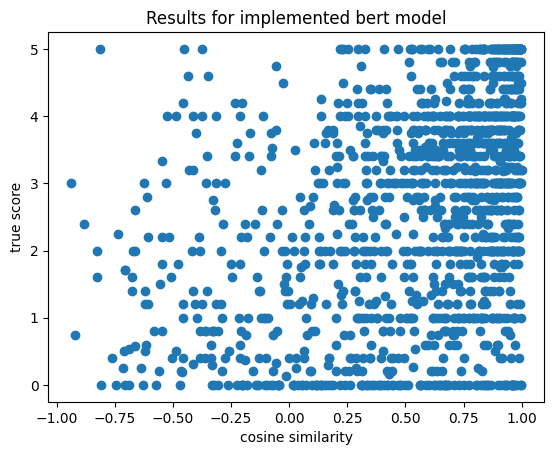

In [ ]:
# Lets visualize the data and compare it with the
plt.scatter(results_from_contrastive[2],results_from_contrastive[3])
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for implemented bert model")
plt.show()

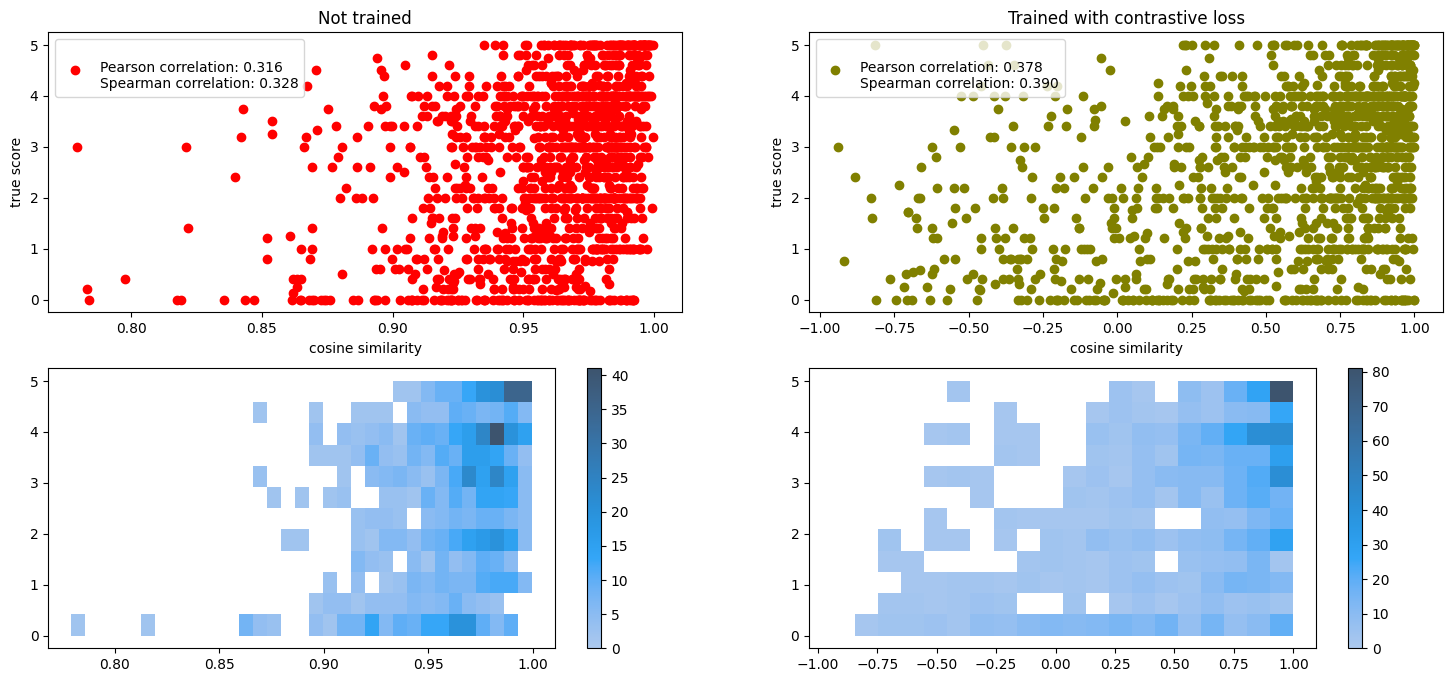

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2,2, figsize = (18,8))

# Plot data on each subplot
axs[0][0].scatter(results_from_pretrained[2],results_from_pretrained[3], c='red',
            label = f'\nPearson correlation: {results_from_pretrained[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained[1].statistic:.3f}' )
axs[0][1].scatter(results_from_contrastive[2],results_from_contrastive[3], c = 'olive',
            label=f'\nPearson correlation: {results_from_contrastive[0].statistic:.3f}\nSpearman correlation: {results_from_contrastive[1].statistic:.3f}')
# Plot histograms to check that the lower triangular part of the
sns.histplot(x=results_from_pretrained[2],y=results_from_pretrained[3],pthresh=.01,
             kde=True, cbar = True, ax= axs[1][0]) # cmap="mako",
sns.histplot(x=results_from_contrastive[2],y=results_from_contrastive[3],pthresh=.01, kde= True, cbar = True,  ax= axs[1][1])

# Set x and y-axis labels for each subplot
axs[0][0].set_xlabel('cosine similarity')
axs[0][0].set_ylabel('true score')

axs[0][1].set_xlabel('cosine similarity')
axs[0][1].set_ylabel('true score')

# Set title for each subplot
axs[0][0].set_title('Not trained')
axs[0][1].set_title('Trained with contrastive loss')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')

# Display the figure with subplots
plt.show()

The contrastive training did not give the Spearman correlation that I expected, but it diminished the anisotropy fo the embeddings. Also, we can check that the model provided opposite emebddigs to un correlated sentences, unfortunately, it has also trained to increase the varation of the embeddings, which is diminishing its predictive power. Nonetheless, we can see that it is learning properly the fact that is needs to move uncorrealted sentence embeddings away.

Now I wanto to check if we can get better results by no averaging the loss for each batch, but instead adding the losses for all the elements of the batch.

In [ ]:
# Lets check is we get a different behaviour by training without averaging the losses
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels =3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
               }
bert_path = 'bert_tiny.bin'

# Load model an tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_4_no_average_loss = Bert(bert_config).load_model('bert_tiny.bin')
# Create contrastive model
bert_contrastive_no_average_loss = BertContrastive(bert_4_no_average_loss, average_loss=False)
#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive_no_average_loss.parameters(), lr=5e-5)
train_loop(bert_contrastive_no_average_loss, optimizer, train_dataloader_contrastive, num_epochs, device, verbose = True)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

In [ ]:
# Lets check the value of the Spearman correlation of the model trained with a contrastive loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_contrastive_no_average_loss = eval_loop(bert_contrastive_no_average_loss.bert_encoder, test_dataloader, device)

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]

In [ ]:
# Lets check the confidence interval of the correlation coefficients to check if the results of our model
# correspond to the results of the model loaded with the hugging face library i.e. the expected results
print(f' Pearson correlation: {results_from_contrastive_no_average_loss[0].statistic:.2f} \n Spearman correlation: {results_from_contrastive_no_average_loss[1].statistic:.2f}')
print(f" Pearson correlation {results_from_contrastive_no_average_loss[0].statistic:.5f}, confidence intervals {results_from_contrastive_no_average_loss[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_contrastive_no_average_loss[1].pvalue:.8f}")

 Pearson correlation: 0.36 
 Spearman correlation: 0.38
 Pearson correlation 0.36189, confidence intervals ConfidenceInterval(low=0.3151230544667071, high=0.4069057269024407)
 Spearman Hipothesis test pvalue 0.00000000


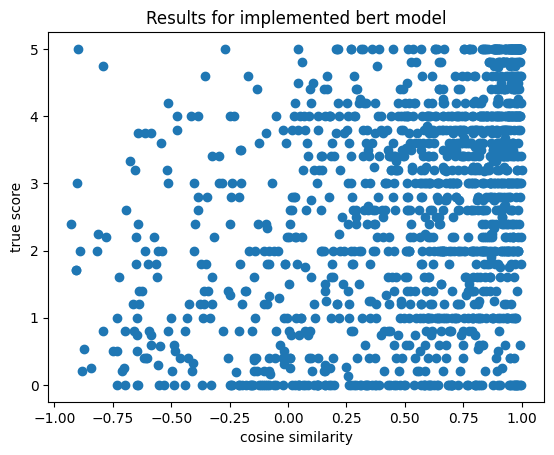

In [ ]:
# Lets visualize the data and compare it with the
plt.scatter(results_from_contrastive_no_average_loss[2],results_from_contrastive_no_average_loss[3])
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for implemented bert model")
plt.show()

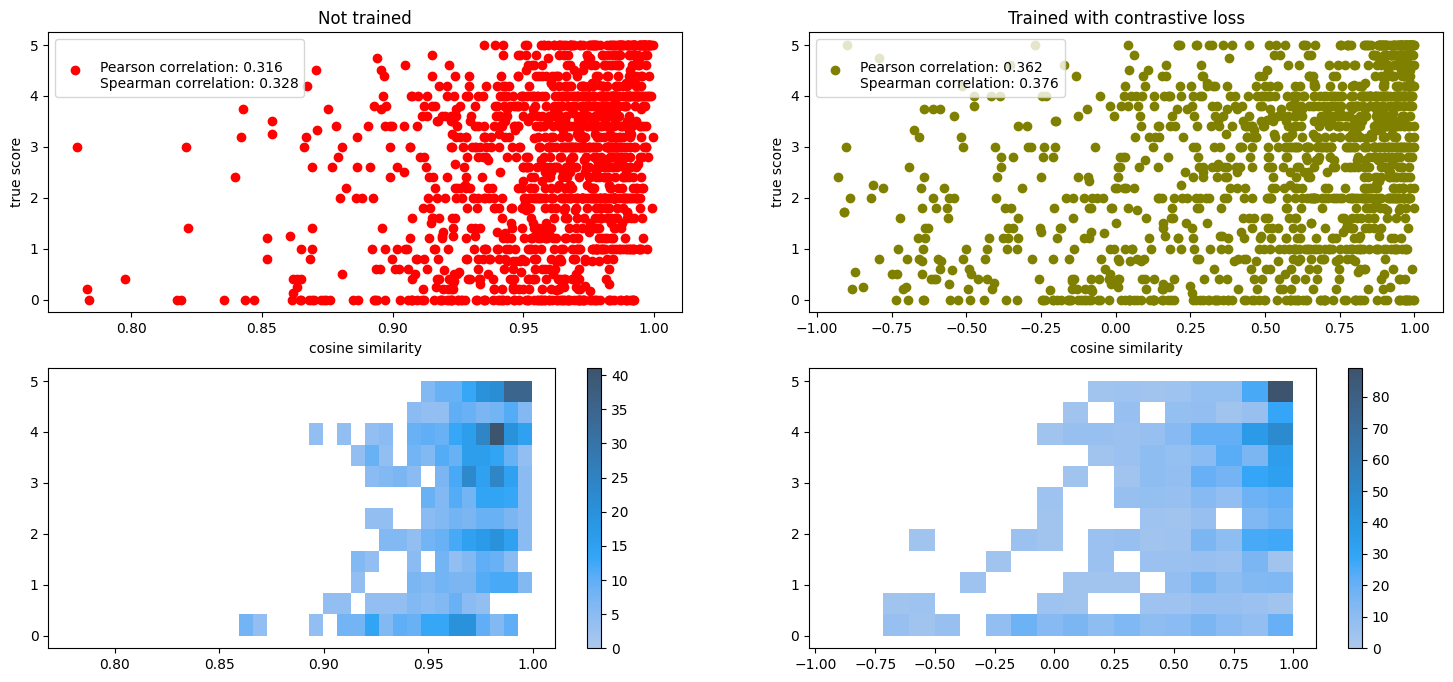

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2,2, figsize = (18,8))

# Plot data on each subplot
axs[0][0].scatter(results_from_pretrained[2],results_from_pretrained[3], c='red',
            label = f'\nPearson correlation: {results_from_pretrained[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained[1].statistic:.3f}' )
axs[0][1].scatter(results_from_contrastive_no_average_loss[2],results_from_contrastive_no_average_loss[3], c = 'olive',
            label=f'\nPearson correlation: {results_from_contrastive_no_average_loss[0].statistic:.3f}\nSpearman correlation: {results_from_contrastive_no_average_loss[1].statistic:.3f}')
# Plot histograms to check that the lower triangular part of the
sns.histplot(x=results_from_pretrained[2],y=results_from_pretrained[3],pthresh=.01,
             kde=True, cbar = True, ax= axs[1][0]) # cmap="mako",
sns.histplot(x=results_from_contrastive_no_average_loss[2],y=results_from_contrastive_no_average_loss[3]
             ,pthresh=.01, kde= True, cbar = True,  ax= axs[1][1])

# Set x and y-axis labels for each subplot
axs[0][0].set_xlabel('cosine similarity')
axs[0][0].set_ylabel('true score')

axs[0][1].set_xlabel('cosine similarity')
axs[0][1].set_ylabel('true score')

# Set title for each subplot
axs[0][0].set_title('Not trained')
axs[0][1].set_title('Trained with contrastive loss')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')

# Display the figure with subplots
plt.show()

We are getting slightly worst resutls when I do not average the loss of the samples in the batch. Lets check what happens if try to force the neutral samples to be ortogonal, my guess is that it will increase the dispersion of the cosine similarities and give worst Sepearman correlation.

In [ ]:
# Lets check is we get a different behaviour by training without averaging the losses
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels =3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128,
               "num_attention_heads": 2,
               "num_hidden_layers": 2,
               "intermediate_size": 512,
               "vocab_size": 30522,
               }
bert_path = 'bert_tiny.bin'

# Load model an tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_2_force_neutral_ort = Bert(bert_config).load_model('bert_tiny.bin')
# Create contrastive model
bert_contrastive_2_force_neutral_ort = BertContrastive(bert_2_force_neutral_ort, enforce_neutral = True)
#bert_contrastive.enforce_neutral=True
#bert_contrastive.average_loss=False
#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive_2_force_neutral_ort.parameters(), lr=5e-5)
train_loop(bert_contrastive_2_force_neutral_ort, optimizer, train_dataloader_contrastive, num_epochs, device, verbose = True)

Iteration over epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

Iteration over batches:   0%|          | 0/12500 [00:00<?, ?it/s]

In [ ]:
# Lets check the value of the Spearman correlation of the model trained with a contrastive loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_contrastive_2_force_neutral_ort = eval_loop(bert_contrastive_2_force_neutral_ort.bert_encoder, test_dataloader, device)

Iterating over the data:   0%|          | 0/345 [00:00<?, ?it/s]

In [ ]:
# Lets check the confidence interval of the correlation coefficients to check if the results of our model
# correspond to the results of the model loaded with the hugging face library i.e. the expected results
print(f' Pearson correlation: {results_from_contrastive_2_force_neutral_ort[0].statistic:.2f} \n Spearman correlation: {results_from_contrastive_2_force_neutral_ort[1].statistic:.2f}')
print(f" Pearson correlation {results_from_contrastive_2_force_neutral_ort[0].statistic:.5f}, confidence intervals {results_from_contrastive_2_force_neutral_ort[0].confidence_interval(0.95)}")
print(f" Spearman Hipothesis test pvalue {results_from_contrastive_2_force_neutral_ort[1].pvalue:.8f}")

 Pearson correlation: 0.40 
 Spearman correlation: 0.40
 Pearson correlation 0.40359, confidence intervals ConfidenceInterval(low=0.35843407406281264, high=0.4468537846602039)
 Spearman Hipothesis test pvalue 0.00000000


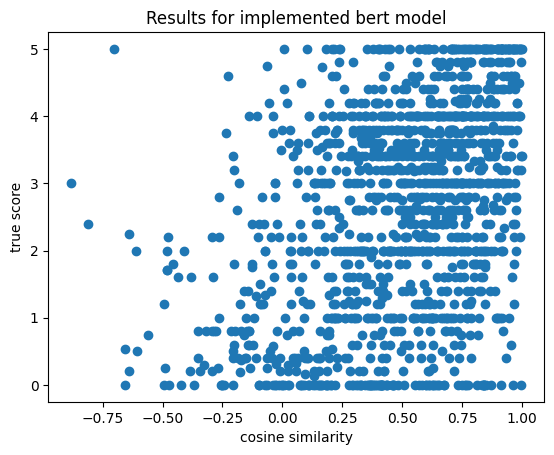

In [ ]:
# Lets visualize the data and compare it with the
plt.scatter(results_from_contrastive_2_force_neutral_ort[2],results_from_contrastive_2_force_neutral_ort[3])
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for implemented bert model")
plt.show()

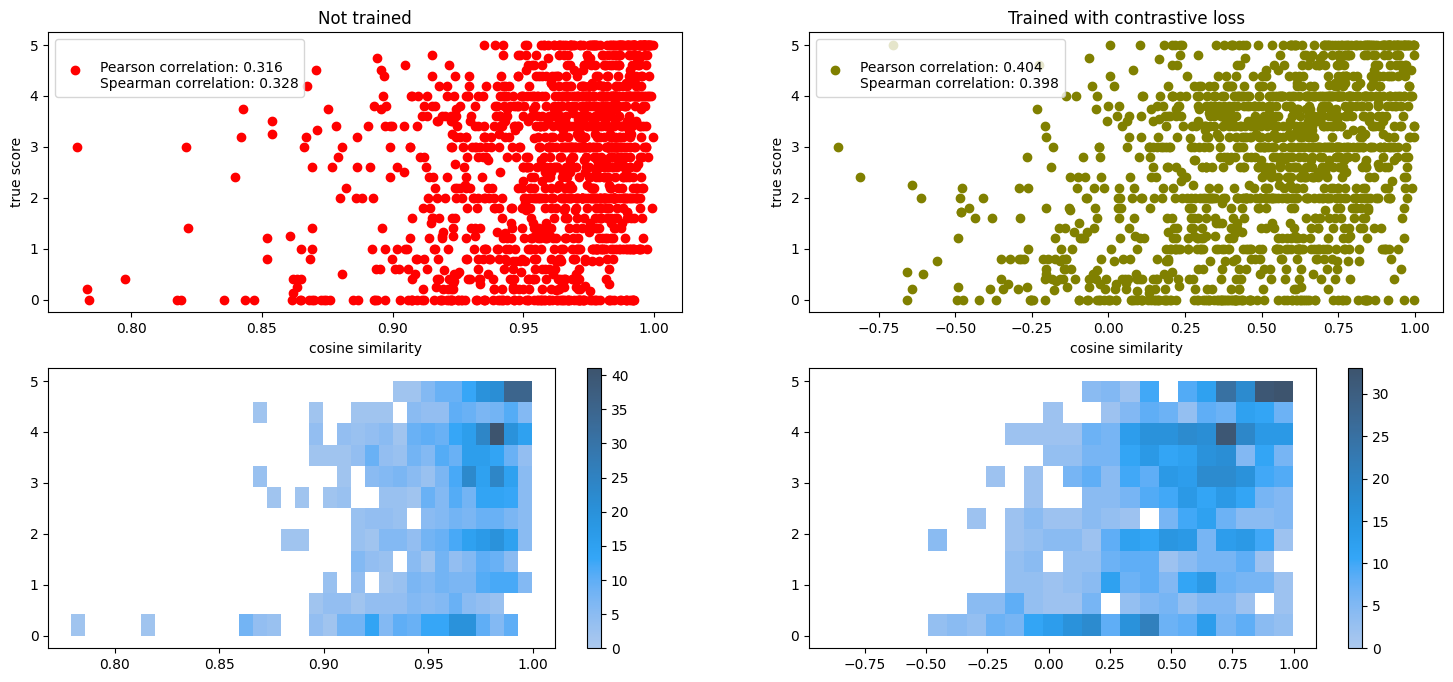

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2,2, figsize = (18,8))

# Plot data on each subplot
axs[0][0].scatter(results_from_pretrained[2],results_from_pretrained[3], c='red',
            label = f'\nPearson correlation: {results_from_pretrained[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained[1].statistic:.3f}' )
axs[0][1].scatter(results_from_contrastive_2_force_neutral_ort[2],results_from_contrastive_2_force_neutral_ort[3], c = 'olive',
            label=f'\nPearson correlation: {results_from_contrastive_2_force_neutral_ort[0].statistic:.3f}\nSpearman correlation: {results_from_contrastive_2_force_neutral_ort[1].statistic:.3f}')
# Plot histograms to check that the lower triangular part of the
sns.histplot(x=results_from_pretrained[2],y=results_from_pretrained[3],pthresh=.0001,
             kde=True, cbar = True, ax= axs[1][0]) # cmap="mako",
sns.histplot(x=results_from_contrastive_2_force_neutral_ort[2],y=results_from_contrastive_2_force_neutral_ort[3],
             pthresh=.0001, kde= True, cbar = True,  ax= axs[1][1])

# Set x and y-axis labels for each subplot
axs[0][0].set_xlabel('cosine similarity')
axs[0][0].set_ylabel('true score')

axs[0][1].set_xlabel('cosine similarity')
axs[0][1].set_ylabel('true score')

# Set title for each subplot
axs[0][0].set_title('Not trained')
axs[0][1].set_title('Trained with contrastive loss')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')

# Display the figure with subplots
plt.show()

As expected we have more dispersion when we try to force neutral elements fo be perpendicular, also, we get a small diminish in the amount of points with close to 1 cosine similarity and low score. Notice that the 95% confidence intervals for the pearson correlation are beggier for the training that kaes neutral elements into account.

# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

**Results**
- We are getting a worst Spearman correlation when training with the contrastive loss, however, we are getting a better usage of the latent space when training with the contrastive loss.
- We are getting a greater dispersion when trainig with the contrastive loss, which we kind of expected since we where forcing disimilar vectors to be appart.
- I was not expeting to get quality embeddings from the softmax classifier with respect to the cosine similarity, cause it does not have enough information to propely compute the cosine similarity. Rather, I was expecting an anisotropic distribution of the embeddings concentrated around six vectors that come from the matrix used for the softmax classifier, as we explained in [the analysis of the results from the softmax classifier](#scrollTo=aivO1C_-N60P).

From the [SimCSE paper](https://arxiv.org/pdf/2104.08821.pdf) and [the exMples fo the Sentence Transformer package](https://github.com/UKPLab/sentence-transformers/tree/master/examples/training/nli#multiplenegativesrankingloss) we know that the contrastive setting is better suited to provide good quality word embeddigns, however, for that to work is necessary to use in batch negatives. I do not fully understand why, but using in batch negatives helps to capture better semantic similarities, this looks like a tyupe of data augmentation where we want to create embeddings that can distinguish as many sentences from the one we are giving, isntead of just one sentence that comes in the form of a negative pair.

So, in conclussion,
- Contrastive learning provide us with better distributed embeddings, however, we need to implemente in batch negatives to teach the model to distinguish semantic similarity using the cosine similariy.
- The pairs of sentences in the STS and the AllNLI datasets are quites similar, so that training in one dataset allow us to improve the performance de model on the other.
- The softmax calssifier is not designed to use the informaiton on the cosine similarity fo predict semantic similarity, thus, the trained embeddings are not as uniformly distributed over the latent space.
- We are training a model for symmetric semantic search, since the lenght of both sentences used in the siamese BERT encoder have approximatley the same lenght.

In [ ]:
# Lets check that both datasets contain similar information
print("STS dataset")
pp(sts_dataset['train'][:10])

print("\n NLI dataset")
pp(nli_dataset_contrastive['train'][:10])

STS dataset
array([['A plane is taking off.', 'An air plane is taking off.', 5.0],
       ['A man is playing a large flute.', 'A man is playing a flute.',
        3.8],
       ['A man is spreading shreded cheese on a pizza.',
        'A man is spreading shredded cheese on an uncooked pizza.', 3.8],
       ['Three men are playing chess.', 'Two men are playing chess.',
        2.6],
       ['A man is playing the cello.',
        'A man seated is playing the cello.', 4.25],
       ['Some men are fighting.', 'Two men are fighting.', 4.25],
       ['A man is smoking.', 'A man is skating.', 0.5],
       ['The man is playing the piano.',
        'The man is playing the guitar.', 1.6],
       ['A man is playing on a guitar and singing.',
        'A woman is playing an acoustic guitar and singing.', 2.2],
       ['A person is throwing a cat on to the ceiling.',
        'A person throws a cat on the ceiling.', 5.0]], dtype=object)

 NLI dataset
array([['A person on a horse jumps over a broken do

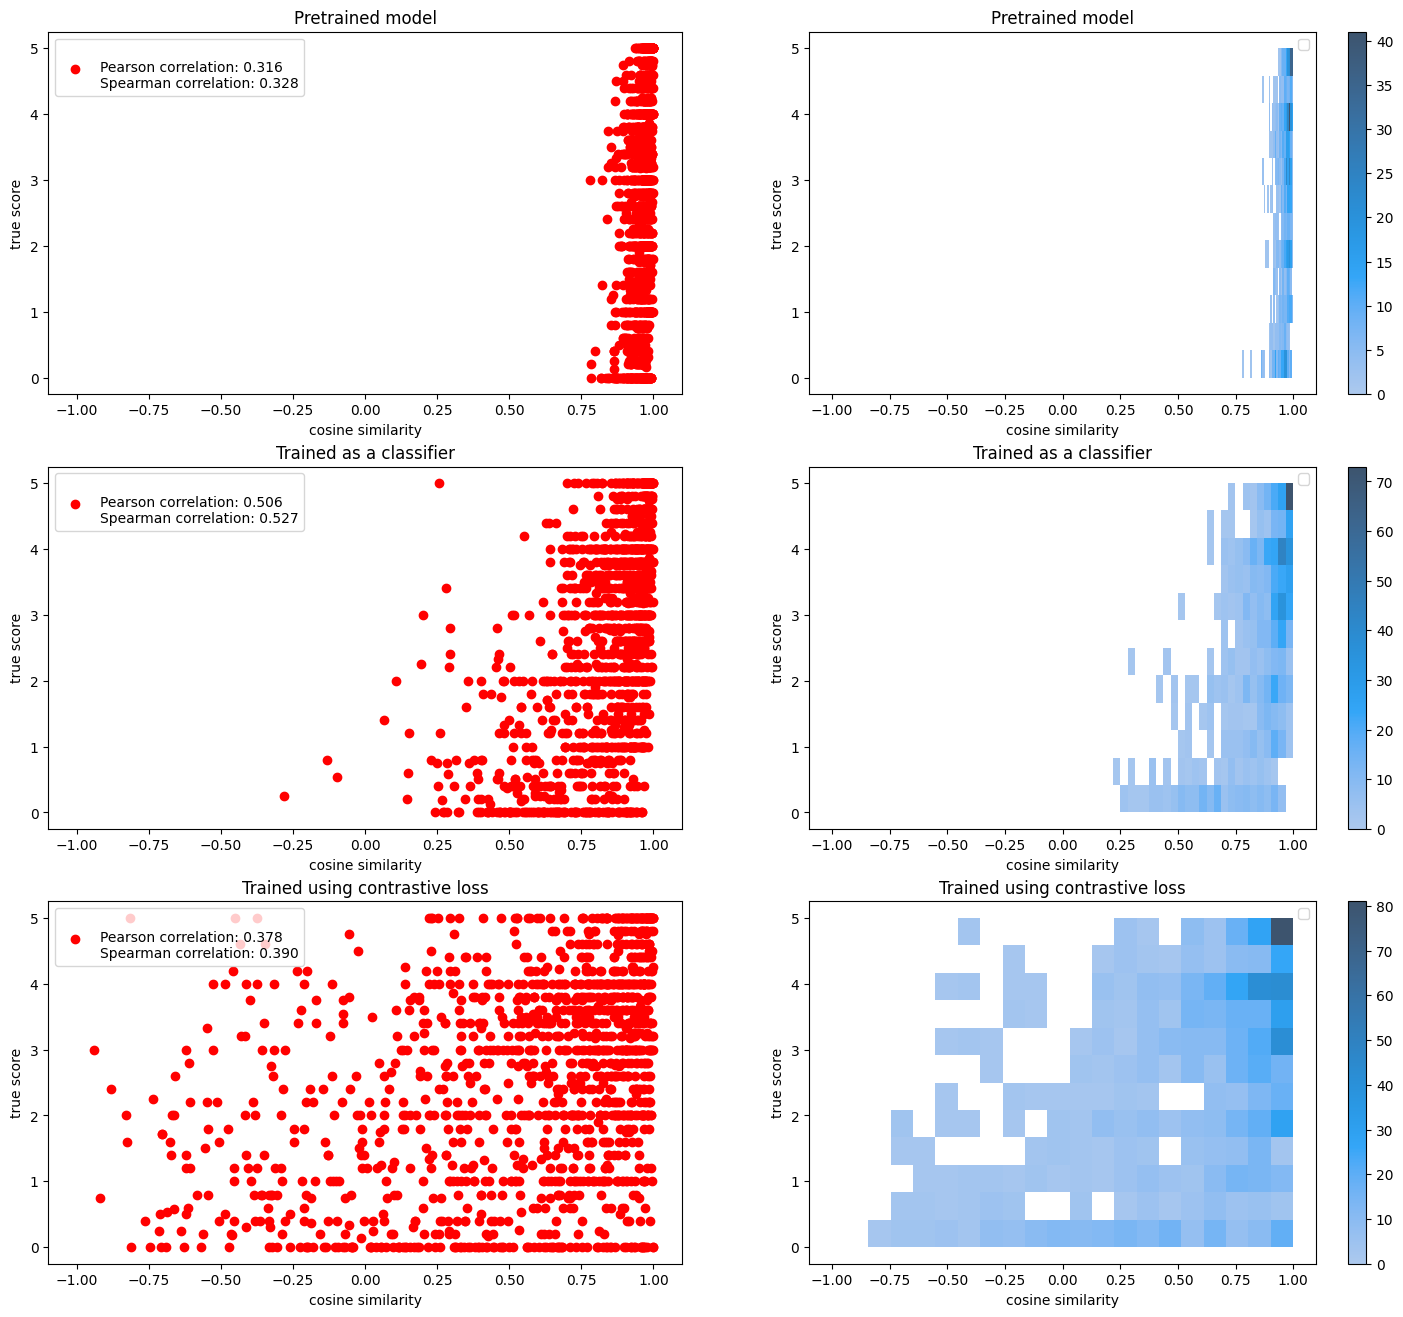

In [ ]:
# Plot of the results of each model and
# Create a figure and a set of subplots
fig, axs= plt.subplots(3,2, figsize = (18,16))

# Pretrained model
axs[0][0].scatter(results_from_pretrained[2],results_from_pretrained[3], c='red',
            label = f'\nPearson correlation: {results_from_pretrained[0].statistic:.3f}\nSpearman correlation: {results_from_pretrained[1].statistic:.3f}' )
sns.histplot(x=results_from_pretrained[2],y=results_from_pretrained[3],pthresh=.0001,
             kde=True, cbar = True, ax= axs[0][1]) # cmap="mako",


# Set x and y-axis labels for each subplot
axs[0][0].set_xlabel('cosine similarity')
axs[0][0].set_ylabel('true score')

axs[0][1].set_xlabel('cosine similarity')
axs[0][1].set_ylabel('true score')

# Set title for each subplot
axs[0][0].set_title('Pretrained model')
axs[0][1].set_title('Pretrained model')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')

# Set limit of the x axis to compare the models
axs[0][0].set_xlim(-1.1,1.1)
axs[0][1].set_xlim(-1.1,1.1)

# Trained as a classifier
axs[1][0].scatter(results_from_classification[2],results_from_classification[3], c='red',
            label = f'\nPearson correlation: {results_from_classification[0].statistic:.3f}\nSpearman correlation: {results_from_classification[1].statistic:.3f}' )
sns.histplot(x=results_from_classification[2],y=results_from_classification[3],pthresh=.0001,
             kde=True, cbar = True, ax= axs[1][1]) # cmap="mako",

# Set x and y-axis labels for each subplot
axs[1][0].set_xlabel('cosine similarity')
axs[1][0].set_ylabel('true score')

axs[1][1].set_xlabel('cosine similarity')
axs[1][1].set_ylabel('true score')

# Set title for each subplot
axs[1][0].set_title('Trained as a classifier')
axs[1][1].set_title('Trained as a classifier')

# set information
axs[1][0].legend(loc='best')
axs[1][1].legend(loc='best')

# Set limit of the x axis to compare the models
axs[1][0].set_xlim(-1.1,1.1)
axs[1][1].set_xlim(-1.1,1.1)


# Trained with contrastive loss
axs[2][0].scatter(results_from_contrastive[2],results_from_contrastive[3], c='red',
            label = f'\nPearson correlation: {results_from_contrastive[0].statistic:.3f}\nSpearman correlation: {results_from_contrastive[1].statistic:.3f}' )
sns.histplot(x=results_from_contrastive[2],y=results_from_contrastive[3],pthresh=.0001,
             kde=True, cbar = True, ax= axs[2][1]) # cmap="mako",


# Set x and y-axis labels for each subplot
axs[2][0].set_xlabel('cosine similarity')
axs[2][0].set_ylabel('true score')

axs[2][1].set_xlabel('cosine similarity')
axs[2][1].set_ylabel('true score')

# Set title for each subplot
axs[2][0].set_title('Trained using contrastive loss')
axs[2][1].set_title('Trained using contrastive loss')

# set information
axs[2][0].legend(loc='best')
axs[2][1].legend(loc='best')

# Set limit of the x axis to compare the models
axs[2][0].set_xlim(-1.1,1.1)
axs[2][1].set_xlim(-1.1,1.1)

# Display the figure with subplots
plt.show()


# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

**I will treat this point as an independent notebook, so that we do not have to worry about the RAM comsuption from the undeleted varaibles and datasets of the previous points**

## Context: improving sentence embeddings


I have found many ways of improving the sentence embeddings, ranging from using various data augmentation techniques for unsupervised learning ([SimCSE](https://arxiv.org/pdf/2104.08821.pdf)), to implementing asymmetric embedings to create recomendation systems based of product titles ([RecoBERT](https://paperswithcode.com/paper/recobert-a-catalog-language-model-for-text)). Various more can be find in [Lilian weng blog](https://lilianweng.github.io/posts/2021-05-31-contrastive/#language-sentence-embedding), and in the papwer of NLP researchers e.g. [Avi Caciularu](https://aviclu.github.io/publications/). I imagine the amount of proposals regarding the procedures to increase the quality of sentence embeddings has increase exponentially in the last 5 years after the publication of the BERT model in 2018, so, I will stop my search for inspiration to tackle this point for the sake of time (and mental sanity XD).


- Lets talk abouit the elephant in the room: according to what I have explained, the natural way to tackle this point would be to use an example from Sentence-Transformers package:

  - For example, we use in-batch negatives to train sentence embeddings, since Sentence-Transformers has examples for that: https://github.com/UKPLab/sentence-transformers/tree/master/examples/training/nli.
    Notice that this approach is similar the one proposed by  [Simple Contrastive Learning of Sentence Embeddings](https://arxiv.org/pdf/2104.08821.pdf).
  - Implement a cross encoder and use it to create a pipeline of semantic search as exposed in the examples of [Sentence-Transformers](https://www.sbert.net/examples/applications/retrieve_rerank/README.html).  
  - Use the Quora duplicate sentences dataset to perform semantic search using sentence embeddings models: https://www.sbert.net/examples/training/quora_duplicate_questions/README.html
  - Perform domain adaptation for sentence embeddings: https://www.sbert.net/examples/domain_adaptation/README.html
  - Fine tune the BERT model to perform topic modeling:https://www.sbert.net/examples/applications/clustering/README.html. I have came across the package BertTopic a couple of times, so, I would love to use to opportunity to use it, unfortunately it does not provide a pipelines to improve the sentence embeddings besides the one provided by Sentence-Transformers.
  - Perform data augmentation using the [Agumented SBERT framework](https://www.sbert.net/examples/training/data_augmentation/README.html?highlight=sts#augmented-sbert).
  - Use an [student-teacher framework to create a BERT embedding that works in various languages](https://github.com/UKPLab/sentence-transformers/tree/master/examples/training/multilingual), this setup consists on making the student BERT model to map parallel sentences into close embeddings. Given this setup the embedding has semantice information of sentences in various languages.
  - Train an asymmetric search algorithm, that is, given a query find the vector that corresponds to the result of the search, https://www.sbert.net/examples/unsupervised_learning/query_generation/README.html?highlight=asymmetric.
  - Many mor examples from the Sentence Transformers library: https://github.com/UKPLab/sentence-transformers/tree/master/examples

- Implement the un supervised strategy from [Simple Contrastive Learning of Sentence Embeddings](https://arxiv.org/pdf/2104.08821.pdf), were the data agumentation is done uwing the dropout probability.
  - We can look at other unsupervised strategies too, like using mutual information to train the embeddings (https://lilianweng.github.io/posts/2021-05-31-contrastive/#mutual-information-maximization).
  - Use text augmentation techniques (https://lilianweng.github.io/posts/2021-05-31-contrastive/#text-augmentation).

- Reproduce the implementation of a RecoBERT model, which uses asymmetric search couple with 4 scores for similarity:
  - paper: https://paperswithcode.com/paper/recobert-a-catalog-language-model-for-text
  - Unofficial implementation of the paper: https://github.com/r-papso/recobert



---

**Additional methods of evaluating the models**

- We can use different measures for the predictive power of the cosine similarity as a semantic similarity measure. For example, we can use
  - The Chatterjee correlation so we can measure dependence. We may need to use bootstrapping to compute the confidence interval of the statistic:
    - https://observablehq.com/@tophtucker/chatterjee-correlation
    - https://statisticaloddsandends.wordpress.com/2020/02/28/a-correlation-coefficient-that-measures-the-degree-of-dependence-between-variables/
    - https://www.youtube.com/watch?v=rqT_eh8qbvw


- Evaluation: Ww can also look into running the evaluation toolkit for the embeddings that are trained, for this we would use the SentEval (https://github.com/facebookresearch/SentEval) toolkit from facebook, which additionally is used in the SentenceBert paper (https://arxiv.org/pdf/1908.10084.pdf). This toolkit trains a logistic regresor based on the embeddingd and quantifies its performance.

- Evaluate the quality of the embeddings (alignement) and the ansirotopy by computing the alignement and uniformity matrics from https://arxiv.org/pdf/2104.08821.pdf. Also, look at the distributions of the various subgroups of scores from the STS dataset as is done in the Appendix F of the aforementioned paper.

---




## Approach


I am new to the Sentence Transformer library, so, I will be cautios wiht my approach, which means that I will try to run a couple of examples from its [github repo](https://github.com/UKPLab/sentence-transformers/tree/master/examples) and I'll try to explain why those are improvements over the setting we have provided in the previous cells. Following the common saying 'crawl, walk, run', I will take the following route:

1. I'll start trying to reproduce the example about the [SimCSE implementation](https://github.com/UKPLab/sentence-transformers/tree/master/examples/unsupervised_learning/SimCSE), which corresponds to the framework described in the [paper SimCSE](https://arxiv.org/pdf/2104.08821.pdf). A description of the approach is also describe in the [official doumentation of the Sentence Transformers library](https://www.sbert.net/examples/unsupervised_learning/SimCSE/README.html?highlight=multiplenegativesrankingloss).
  - In this papers is proposed to use in batch negatives for contrastive learning of sentence embeddings, and also they use the dropout of the attention layers as a data agumentation technique. First we will focus on the unsupervised setting, and then we will try to implement the usage of hard negatives. The improvement over our approach relays in:
    - The approach is unsupervised, meaning that it is easier to implement since we do not need to get a label dataset.
    - It provides a less anisotropic distribution of the emneddings in the latent space, meaning that we are giving a best usage of the latent space.

  A similar approach would be so use [contrastive tension](https://github.com/UKPLab/sentence-transformers/tree/master/examples/unsupervised_learning/CT_In-Batch_Negatives)

2. If poitn 1 goes well I will try to run the [example](https://github.com/UKPLab/sentence-transformers/tree/master/examples/unsupervised_learning/query_generation) on how to create syntetic queris using a T5 model and then use them to train an asymmetric semantic search. This approach provides an improvement over our approach because:
 - We can takle asymmetric pairs of sentences, which is a setting that we have not explored in this notebook.
 - We can look on hwo to use LLM to provide sintetic datasets, which is becoming popular now that anotating with OpenAI (an similar services), is becoming a [reliable option](https://www.artisana.ai/articles/gpt-4-outperforms-elite-crowdworkers-saving-researchers-usd500-000-and-20).

In [ ]:
# I will connect to google colab so that I do not need to download the datasets and bin files everytime I execute this notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install the necessary libraries
# Sentences transformers library
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=14eff490cd57ecc891320ee0f376f50c56676de73c9f95471079b1e03d8145ff
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
# import the necessary libraries
from sentence_transformers import SentenceTransformer, LoggingHandler, InputExample, util
from sentence_transformers import models, util, datasets, evaluation, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics.pairwise import paired_cosine_distances
import logging
import os
import gzip
from torch.utils.data import DataLoader
from datetime import datetime
import math
import csv
# To plot
import matplotlib.pyplot as plt
import seaborn as sns

### Example of unsupervised contrastive training and testing the models using a ranking metric

Lets download the dataset, we will us the [AskUbuntu dataset](https://github.com/taolei87/askubuntu), which consists of
- `text_tokenized.txt.gz` pairs of title fo forum questions and their content, the first column of the dataset corresponds to the ID of the question.
- `train_random.txt`, `dev_txt`, `test.txt` lists of IDs for the questions along with the most similar questions, and a set of provided search results (similar question + negative resutls).

In [ ]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

# Some training parameters. For the example, we use a batch_size of 128, a max sentence length (max_seq_length)
# of 32 word pieces and as model roberta-base
model_name = 'roberta-base'
batch_size = 128
max_seq_length = 32
num_epochs = 1

################# Download AskUbuntu and extract training corpus  #################
askubuntu_folder = 'data/askubuntu'
output_path = 'output/askubuntu-simcse-{}-{}-{}'.format(model_name, batch_size, datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

## Download the AskUbuntu dataset from https://github.com/taolei87/askubuntu
for filename in ['text_tokenized.txt.gz', 'dev.txt', 'test.txt', 'train_random.txt']:
    filepath = os.path.join(askubuntu_folder, filename)
    if not os.path.exists(filepath):
        util.http_get('https://github.com/taolei87/askubuntu/raw/master/'+filename, filepath)

# Read the corpus
corpus = {}
dev_test_ids = set()
with gzip.open(os.path.join(askubuntu_folder, 'text_tokenized.txt.gz'), 'rt', encoding='utf8') as fIn:
    for line in fIn:
        splits = line.strip().split("\t")
        id = splits[0]
        title = splits[1]
        corpus[id] = title

# Read dev & test dataset
def read_eval_dataset(filepath):
    dataset = []
    with open(filepath) as fIn:
        for line in fIn:
            query_id, relevant_id, candidate_ids, bm25_scores = line.strip().split("\t")
            if len(relevant_id) == 0:   #Skip examples without relevant entries
                continue

            relevant_id = relevant_id.split(" ")
            candidate_ids = candidate_ids.split(" ")
            negative_ids = set(candidate_ids) - set(relevant_id)
            dataset.append({
                'query': corpus[query_id],
                'positive': [corpus[pid] for pid in relevant_id],
                'negative': [corpus[pid] for pid in negative_ids]
            })
            dev_test_ids.add(query_id)
            dev_test_ids.update(candidate_ids)
    return dataset

dev_dataset = read_eval_dataset(os.path.join(askubuntu_folder, 'dev.txt'))
test_dataset = read_eval_dataset(os.path.join(askubuntu_folder, 'test.txt'))


## Now we need a list of train sentences.
## In this example we simply use all sentences that don't appear in the train/dev set
train_sentences = []
for id, sentence in corpus.items():
    if id not in dev_test_ids:
        train_sentences.append(InputExample(texts=[sentence, sentence]))

logging.info("{} train sentences".format(len(train_sentences)))

  0%|          | 0.00/46.4M [00:00<?, ?B/s]

  0%|          | 0.00/34.7k [00:00<?, ?B/s]

  0%|          | 0.00/34.4k [00:00<?, ?B/s]

  0%|          | 0.00/4.12M [00:00<?, ?B/s]

In [ ]:
################# Intialize an SBERT model #################
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)

# Apply mean pooling
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
################# Train the model #################

# As Loss function, we use MultipleNegativesRankingLoss
train_dataloader = DataLoader(train_sentences, batch_size=batch_size, shuffle=True, drop_last=True)
train_loss = losses.MultipleNegativesRankingLoss(model)

# Create a dev evaluator
dev_evaluator = evaluation.RerankingEvaluator(dev_dataset, name='AskUbuntu dev')
test_evaluator = evaluation.RerankingEvaluator(test_dataset, name='AskUbuntu test')

logging.info("Dev performance before training")
dev_evaluator(model)

warmup_steps = int(num_epochs*len(train_dataloader)*0.1)

logging.info("Start training")
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    evaluation_steps=100,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=output_path,
    show_progress_bar=True,
    use_amp=True                #If your GPU does not have FP16 cores, set use_amp=False
)

latest_output_path = output_path + "-latest"
model.save(latest_output_path)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

The evaluators use a new metric called average precision score, because in this case the [cosine similarity is used to provide a ranking of the quetions based on similarity](https://github.com/UKPLab/sentence-transformers/blob/c5f93f70eca933c78695c5bc686ceda59651ae3b/sentence_transformers/evaluation/RerankingEvaluator.py#L123-L127). Thus, the evaluator uses the [average precision score to check how well the ranking is done](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). It gives a number between 0 and 1, being zero not being able to recover any of the related texts and 1 being able to recover all the related texts in the providede order. We can check taht we get similar results as the one shown in the [TSDAE paper](https://arxiv.org/pdf/2104.06979.pdf) in table 2.  

In [ ]:
################# Intialize an SBERT model #################
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)

# Apply mean pooling
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
## Load the trained model
trained_model = SentenceTransformer(latest_output_path)

In [ ]:
### Run test evaluation on the latest model. This is equivalent to not having a dev dataset
map_score_trained_model = test_evaluator(trained_model)
map_score_untrained_model = test_evaluator(model)
print(f"Score untrained model {map_score_untrained_model:.4f},\nScore for trained model {map_score_trained_model:.4f} ")

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Score untrained model 0.4658,
Score for trained model 0.5517 


### Example: unsupervised learning using contrastive loss, in batch negatives and testing the correlation coefficients on the STS dataset

Now lets run the example that uses the STS dataset, which uses the [EmbeddingSimilarityEvaluator](https://www.sbert.net/docs/package_reference/evaluation.html?highlight=rerankingevaluator#sentence_transformers.evaluation.EmbeddingSimilarityEvaluator), which computes the Spearman and Pearson correlation coefficients, so, we do not need to run any of our code to compute this metris, nice.

In [ ]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

# Training parameters
model_name = 'distilbert-base-uncased'
train_batch_size = 128
num_epochs = 1
max_seq_length = 32

# Save path to store our model
model_save_path = 'output/training_stsb_simcse-{}-{}-{}'.format(model_name, train_batch_size, datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Check if dataset exsist. If not, download and extract  it
sts_dataset_path = 'data/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

# Here we define our SentenceTransformer model
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# We use 1 Million sentences from Wikipedia to train our model
# Official website of the dataset provided by hugging face:
# https://huggingface.co/datasets/princeton-nlp/datasets-for-simcse
wikipedia_dataset_path = 'data/wiki1m_for_simcse.txt'
if not os.path.exists(wikipedia_dataset_path):
    util.http_get('https://huggingface.co/datasets/princeton-nlp/datasets-for-simcse/resolve/main/wiki1m_for_simcse.txt', wikipedia_dataset_path)

# train_samples is a list of InputExample objects where we pass the same sentence twice to texts, i.e. texts=[sent, sent]
train_samples = []
with open(wikipedia_dataset_path, 'r', encoding='utf8') as fIn:
    for line in fIn:
        # Delete blank spaces at the beginning and at the end of the string
        line = line.strip()
        # Add lines that have enought characters so we can consider them as sentences
        if len(line) >= 10:
            train_samples.append(InputExample(texts=[line, line]))

# Read STSbenchmark dataset and use it as development set
logging.info("Read STSbenchmark dev dataset")
dev_samples = []
test_samples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
        # Split the dataset into dev and test, we can create evaluators for each one of them
        if row['split'] == 'dev':
            dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))
        elif row['split'] == 'test':
            test_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

# Create evaluator classes taht compute the Spearman and Pearson correlation coefficients
# https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=train_batch_size, name='sts-dev')
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, batch_size=train_batch_size, name='sts-test')

  0%|          | 0.00/392k [00:00<?, ?B/s]

  0%|          | 0.00/120M [00:00<?, ?B/s]

In [ ]:
# We train our model using the MultipleNegativesRankingLoss, that is, we use the in batch negative strategy to improve the embeddings
# https://www.sbert.net/docs/package_reference/losses.html#multiplenegativesrankingloss
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size, drop_last=True)
train_loss = losses.MultipleNegativesRankingLoss(model)

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
evaluation_steps = int(len(train_dataloader) * 0.1) #Evaluate every 10% of the data
logging.info("Training sentences: {}".format(len(train_samples)))
logging.info("Warmup-steps: {}".format(warmup_steps))
logging.info("Performance before training")
dev_evaluator(model)

# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=dev_evaluator,
          epochs=num_epochs,
          evaluation_steps=evaluation_steps,
          warmup_steps=warmup_steps,
          output_path=model_save_path,
          optimizer_params={'lr': 5e-5},
          use_amp=True         #Set to True, if your GPU supports FP16 cores
          )

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7700 [00:00<?, ?it/s]

In [ ]:
##############################################################################
#
# Load the stored model and evaluate its performance on STS benchmark dataset
#
##############################################################################
trained_model_nli = SentenceTransformer(model_save_path)
correlation_coefficient_trained_model = test_evaluator(trained_model_nli, output_path=model_save_path)
print(f"Trained model: Maximum value between the Pearson and Spearman correlation coefficients: {correlation_coefficient_trained_model : .4f}")

Trained model: Maximum value between the Pearson and Spearman correlation coefficients:  0.7628


In [ ]:
# Lets compute the cosine scores for the trained model, we follow:
# https://github.com/UKPLab/sentence-transformers/blob/c5f93f70eca933c78695c5bc686ceda59651ae3b/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py#L54-L84
embeddings1 = trained_model_nli.encode([example.texts[0] for example in test_samples],convert_to_numpy=True)
embeddings2 = trained_model_nli.encode([example.texts[1] for example in test_samples],convert_to_numpy=True)
scores = [example.label for example in test_samples]
cosine_scores_trained_model = 1 - (paired_cosine_distances(embeddings1, embeddings2))

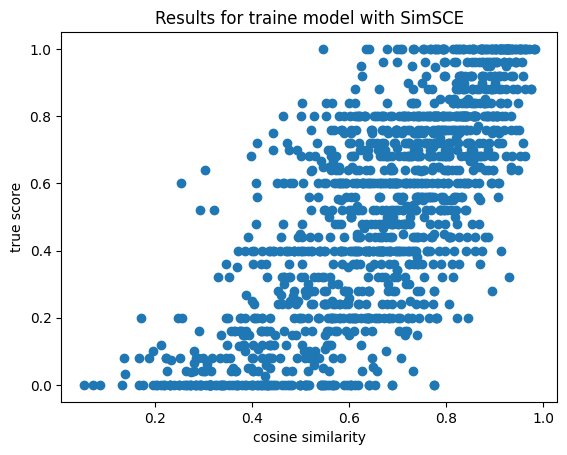

In [ ]:
# Lets visualize the data and compare it with the
plt.scatter(cosine_scores_trained_model,scores)
plt.xlabel("cosine similarity")
plt.ylabel("true score")
plt.title("Results for traine model with SimSCE")
plt.show()

In [ ]:
# Lest compute the cosine scores for the untrained model and compare them
# Laod model
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model_untrained = SentenceTransformer(modules=[word_embedding_model, pooling_model])
# Compute the correlation coefficient
correlation_coefficient_untrained_model = test_evaluator(model_untrained)
print(f"Untrained model: Maximum value between the Pearson and Spearman correlation coefficients: {correlation_coefficient_untrained_model : .4f}")
# Get the cosine scores
embeddings1 = model_untrained.encode([example.texts[0] for example in test_samples],convert_to_numpy=True)
embeddings2 = model_untrained.encode([example.texts[1] for example in test_samples],convert_to_numpy=True)
scores = [example.label for example in test_samples]
cosine_scores_untrained_model = 1 - (paired_cosine_distances(embeddings1, embeddings2))

Untrained model: Maximum value between the Pearson and Spearman correlation coefficients:  0.5887


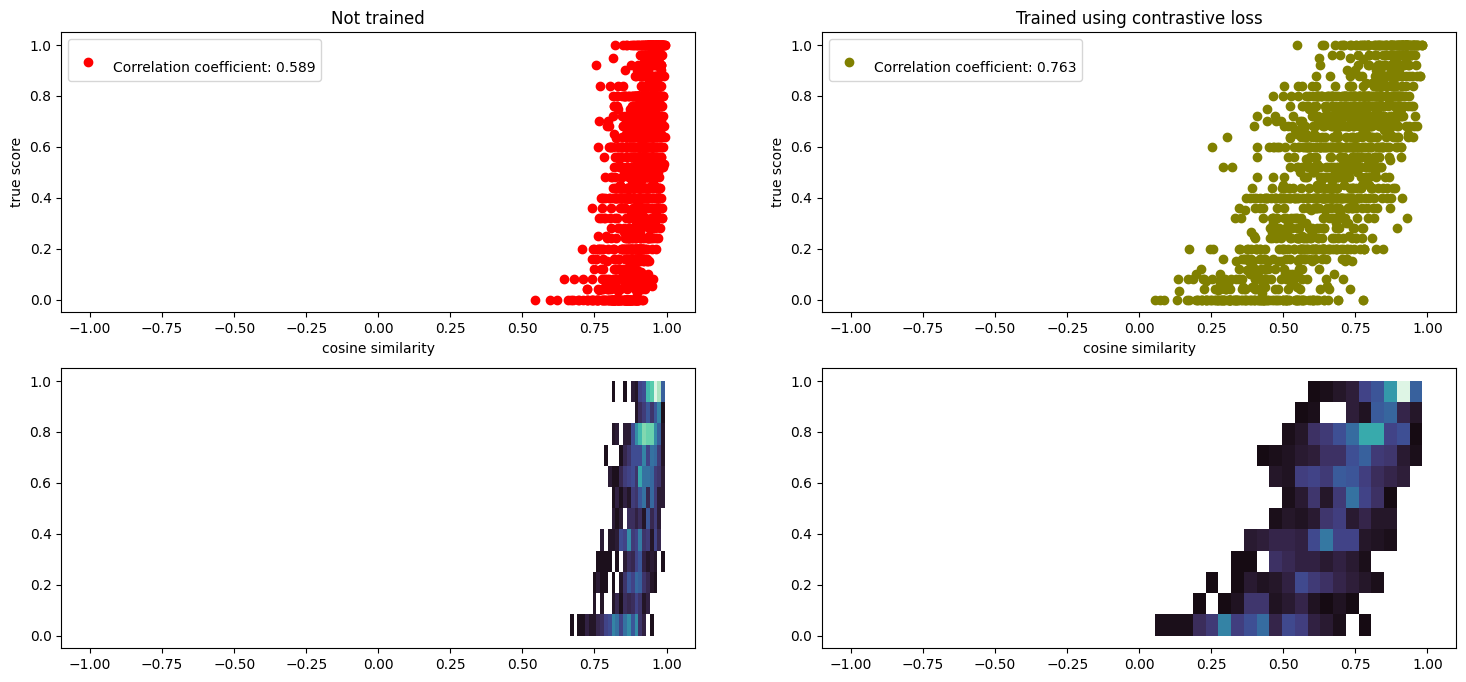

In [ ]:
# Lets plot the scores and the correlations
# Create a figure and a set of subplots
fig, axs = plt.subplots(2,2, figsize = (18,8))

# Plot data on each subplot
axs[0][0].scatter(cosine_scores_untrained_model,scores, c='red',
            label = f'\nCorrelation coefficient: {correlation_coefficient_untrained_model:.3f}' )
axs[0][1].scatter(cosine_scores_trained_model,scores, c = 'olive',
            label=f'\nCorrelation coefficient: {correlation_coefficient_trained_model:.3f}')
# Plot histograms to check that the lower triangular part of the
sns.histplot(x=cosine_scores_untrained_model,y=scores,pthresh=.01, cmap="mako", ax= axs[1][0])
sns.histplot(x=cosine_scores_trained_model,y=scores,pthresh=.01, cmap="mako", ax= axs[1][1])

# Set x and y-axis labels for each subplot
axs[0][0].set_xlabel('cosine similarity')
axs[0][0].set_ylabel('true score')

axs[0][1].set_xlabel('cosine similarity')
axs[0][1].set_ylabel('true score')

# Set title for each subplot
axs[0][0].set_title('Not trained')
axs[0][1].set_title('Trained using contrastive loss')

# set information
axs[0][0].legend(loc='best')
axs[0][1].legend(loc='best')

# Set limits for the x axis
axs[0][0].set_xlim(-1.1,1.1)
axs[0][1].set_xlim(-1.1,1.1)
axs[1][0].set_xlim(-1.1,1.1)
axs[1][1].set_xlim(-1.1,1.1)

# Display the figure with subplots
plt.show()

We can observe how an unsupervised contrastive training helps the model to use better the latent space (the range of the cosine similarities increases), and increases the predictiva power of the cosine similairty, Notice that in this case the lower triangular part of the graphs is beign clear up, thus, we can distinguis if a pair of sentences have big similarity score by computing the cosine similarity and checking that it is greater than 0.9. So, in conclussion, we are getting much better results using the tools from the Sentence Transformers librarye than using our own built tools 🔥.

Now is time for lunch, so, if I do not have enough time to come back and go through the second examples this is the end of ny assignement.

Thanks a lot for the opportunity and I am looking forward to hear from you.

best regards,

Juan Florez.